In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.options.display.max_columns = None

data = pd.read_csv('application_train.csv')
data_test = pd.read_csv('application_test.csv')
numerical_features = set()
categorical_features = set()

In [3]:
data.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
97778,213527,0,Cash loans,M,N,Y,1,189000.0,247275.0,22810.5,225000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.024610,-15352,-7926,-2296.0,-4101,NaN,1,1,1,1,1,0,Managers,3.0,2,2,THURSDAY,15,0,0,0,0,0,0,Government,0.450956,0.695710,0.047929,0.0227,0.0506,0.9871,0.8232,NaN,NaN,0.1034,0.0417,NaN,0.0000,0.0185,0.0197,0.0000,0.0000,0.0231,0.0525,0.9871,0.8301,NaN,NaN,0.1034,0.0417,NaN,0.0000,0.0202,0.0205,0.0000,0.0000,0.0229,0.0506,0.9871,0.8256,NaN,NaN,0.1034,0.0417,NaN,0.000,0.0188,0.0200,0.0000,0.0000,reg oper account,block of flats,0.0175,"Stone, brick",No,1.0,0.0,1.0,0.0,-1601.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
225951,361715,0,Cash loans,M,N,N,1,180000.0,225000.0,12204.0,225000.0,Unaccompanied,Working,Incomplete higher,Married,House / apartment,0.009657,-13193,-91,-7223.0,-4963,NaN,1,1,1,1,0,0,Sales staff,3.0,2,2,MONDAY,9,0,0,0,0,0,0,Other,NaN,0.359510,0.537070,0.0371,0.0291,0.9861,0.8096,0.0061,0.04,0.0345,0.3333,0.375,0.0256,0.0303,0.0419,0.0000,0.0154,0.0378,0.0302,0.9861,0.8171,0.0062,0.0403,0.0345,0.3333,0.375,0.0262,0.0331,0.0436,0.0000,0.0163,0.0375,0.0291,0.9861,0.8121,0.0062,0.04,0.0345,0.3333,0.375,0.026,0.0308,0.0426,0.0000,0.0157,reg oper spec account,block of flats,0.0413,Panel,No,0.0,0.0,0.0,0.0,-1668.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
62305,172254,1,Cash loans,F,N,Y,0,270000.0,1267735.5,37192.5,1107000.0,Unaccompanied,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.025164,-21454,365243,-6946.0,-4657,NaN,1,0,0,1,1,0,NaN,1.0,2,2,FRIDAY,13,0,0,0,0,0,0,XNA,0.864023,0.606936,0.269286,0.3299,0.1885,0.9846,0.7892,0.1132,0.36,0.3103,0.3333,0.375,0.0000,0.2656,0.3433,0.0154,0.0198,0.3361,0.1956,0.9846,0.7975,0.1143,0.3625,0.3103,0.3333,0.375,0

In [4]:
categorical_features |= set(data.select_dtypes(include=['object']).columns)
to_add = {
    "TARGET", "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", 
    "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION",
    "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY",
    "LIVE_CITY_NOT_WORK_CITY", 
}
categorical_features |= to_add
for column in data.columns:
    if column.startswith('FLAG'):
        categorical_features.add(column)
        
for feature in categorical_features:
    data[feature] = data[feature].astype("category")

In [5]:
for column in data.columns:
    if column not in categorical_features:
        numerical_features.add(column)
        
numerical_features.remove("SK_ID_CURR")

In [6]:
num_rows = data.shape[0]
for column in data.columns:
    if (data[column].isnull().sum() / num_rows) > 0.4: # 123,000 NaN, if more than 40% is NaN TODO remove
        print(column, data[column].isnull().sum())
#         try:
#             categorical_features.remove(column)
#         except KeyError:
#             pass
        
#         try:
#             numerical_features.remove(column)
#         except KeyError:
#             pass
#         data = data.drop(columns=[column])


OWN_CAR_AGE 202929
EXT_SOURCE_1 173378
APARTMENTS_AVG 156061
BASEMENTAREA_AVG 179943
YEARS_BEGINEXPLUATATION_AVG 150007
YEARS_BUILD_AVG 204488
COMMONAREA_AVG 214865
ELEVATORS_AVG 163891
ENTRANCES_AVG 154828
FLOORSMAX_AVG 153020
FLOORSMIN_AVG 208642
LANDAREA_AVG 182590
LIVINGAPARTMENTS_AVG 210199
LIVINGAREA_AVG 154350
NONLIVINGAPARTMENTS_AVG 213514
NONLIVINGAREA_AVG 169682
APARTMENTS_MODE 156061
BASEMENTAREA_MODE 179943
YEARS_BEGINEXPLUATATION_MODE 150007
YEARS_BUILD_MODE 204488
COMMONAREA_MODE 214865
ELEVATORS_MODE 163891
ENTRANCES_MODE 154828
FLOORSMAX_MODE 153020
FLOORSMIN_MODE 208642
LANDAREA_MODE 182590
LIVINGAPARTMENTS_MODE 210199
LIVINGAREA_MODE 154350
NONLIVINGAPARTMENTS_MODE 213514
NONLIVINGAREA_MODE 169682
APARTMENTS_MEDI 156061
BASEMENTAREA_MEDI 179943
YEARS_BEGINEXPLUATATION_MEDI 150007
YEARS_BUILD_MEDI 204488
COMMONAREA_MEDI 214865
ELEVATORS_MEDI 163891
ENTRANCES_MEDI 154828
FLOORSMAX_MEDI 153020
FLOORSMIN_MEDI 208642
LANDAREA_MEDI 182590
LIVINGAPARTMENTS_MEDI 210199
LIVING

In [7]:
data[data.duplicated()]
# No duplicated rows

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


In [8]:
data.describe(include="all")

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.0,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,306219,307511,307511,307511,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,211120,307509.000000,307511.0,307511.0,307511,307511.000000,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,97216,153214,159080.000000,151170,161756,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,2.0,2,3,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,18,NaN,3.0,3.0,7,NaN,2.0,2.0,2.0,2.0,2.0,2.0,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,7,2,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,

In [9]:
def plot_categorical(data, col, x_angle=0, title=''):
    plot_data = data[col].value_counts()
    plt.figure(figsize=[12, 4])
    sns.barplot(x=plot_data.index, y=plot_data.values)
    plt.xticks(rotation=x_angle)
    plt.title(title)
    plt.show()
    
def plot_numerical(data, col, type_='hist', title=''):
    plt.figure(figsize=[12, 4])
    plt.title(title)
    if type_ == 'hist':
        sns.histplot(data[col].dropna(), bins=50, kde=True, color="g")
    elif type_ == 'box':
        sns.boxplot(data[col].dropna())
    plt.show()

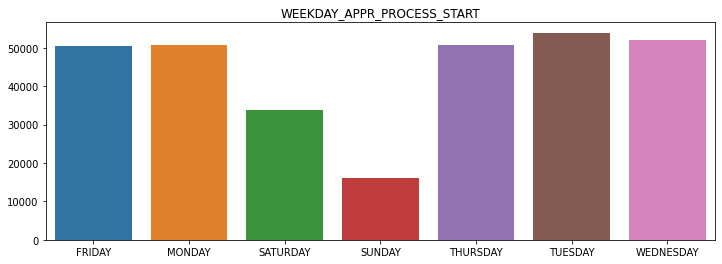

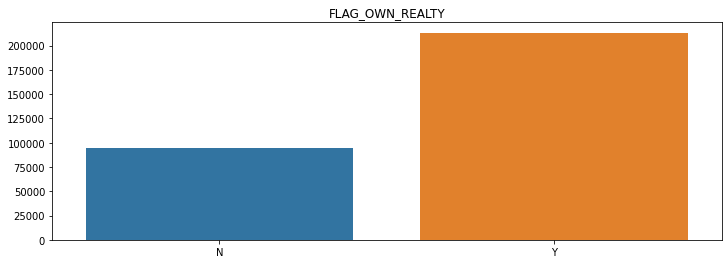

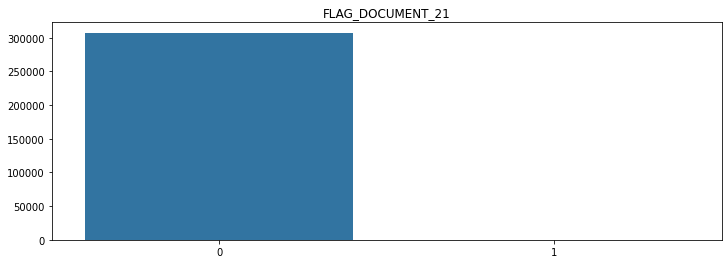

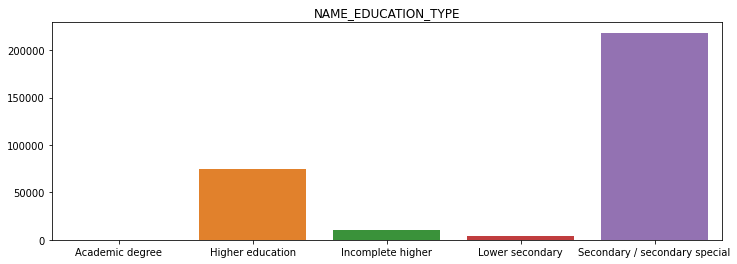

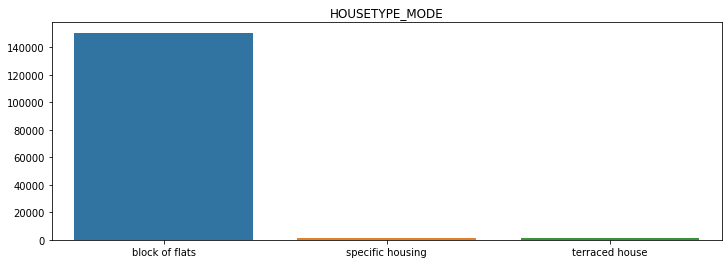

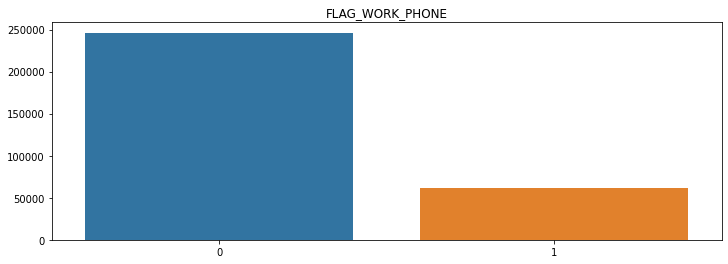

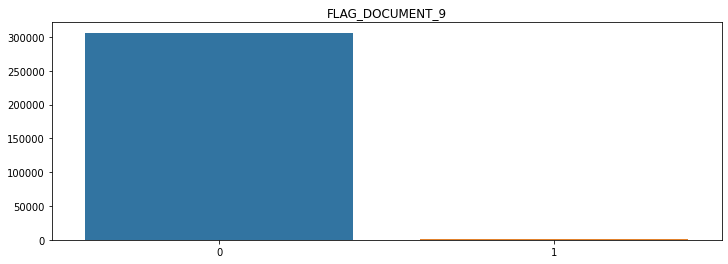

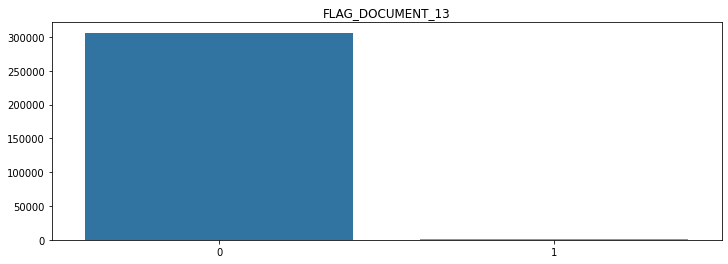

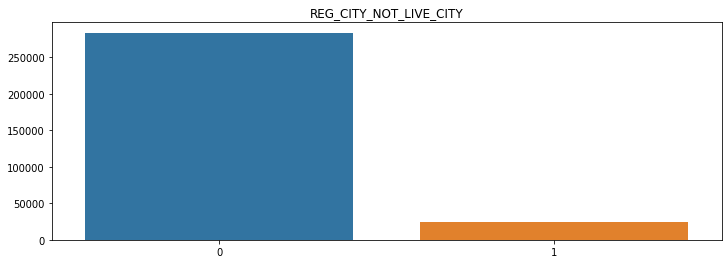

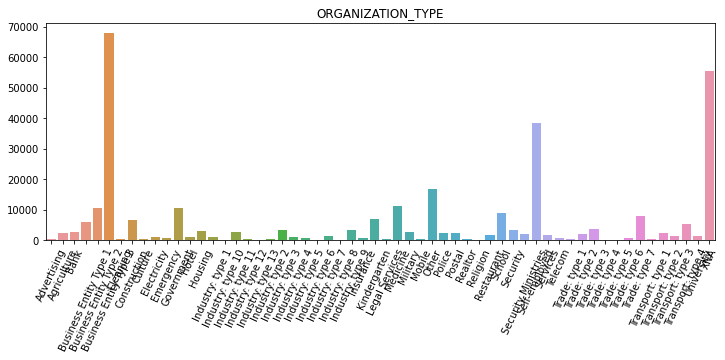

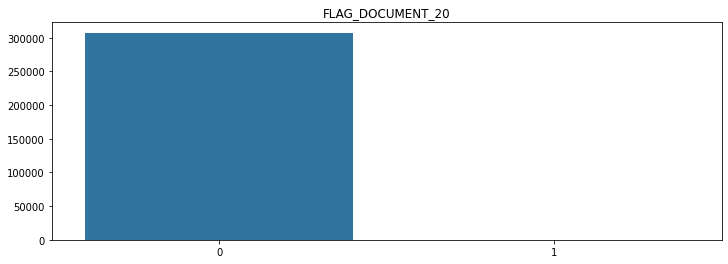

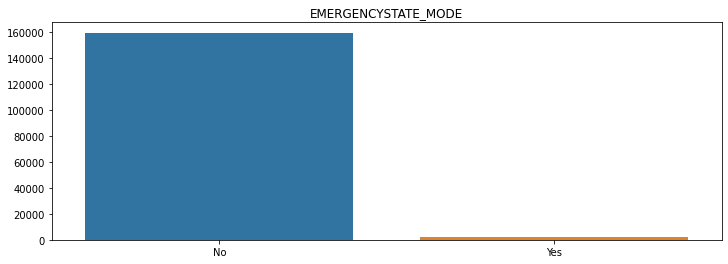

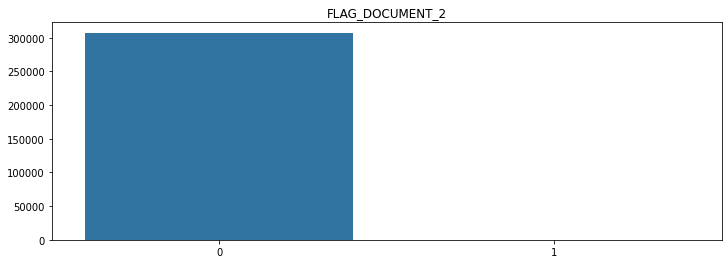

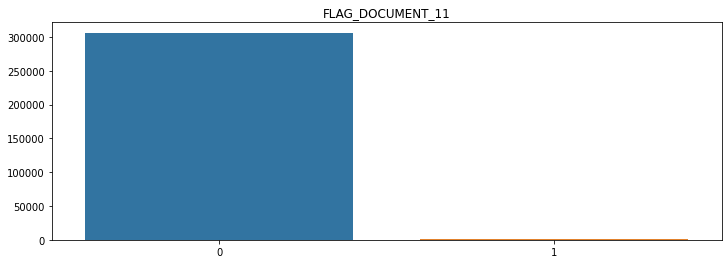

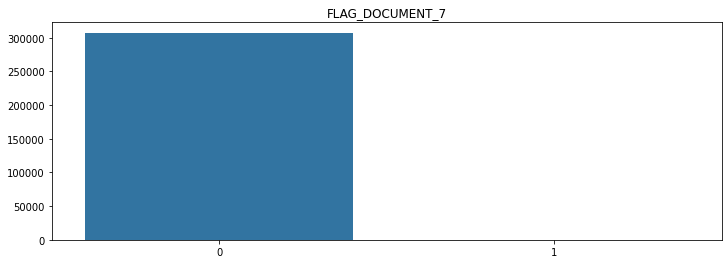

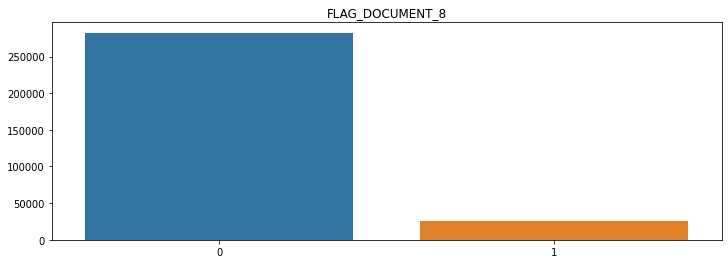

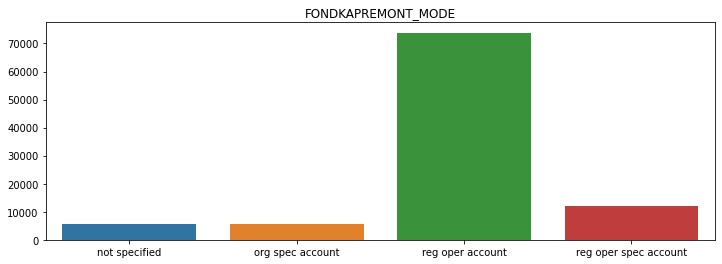

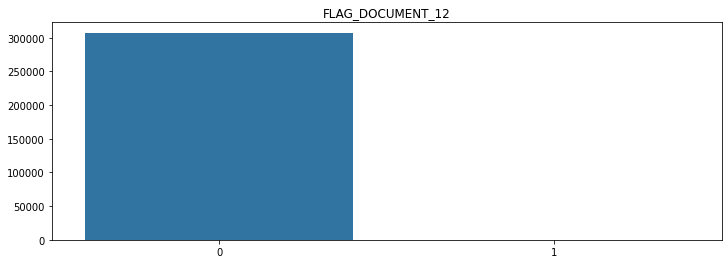

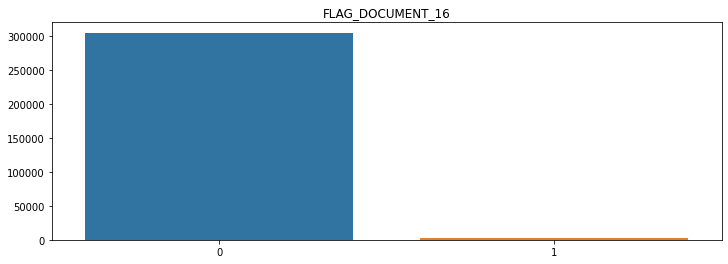

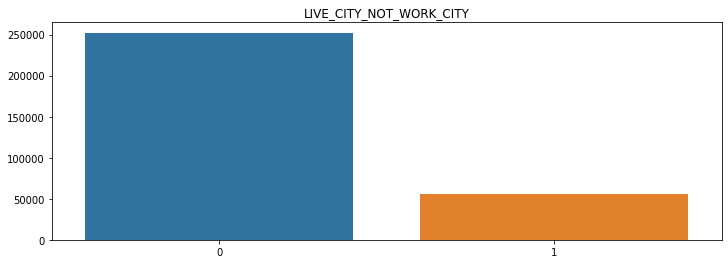

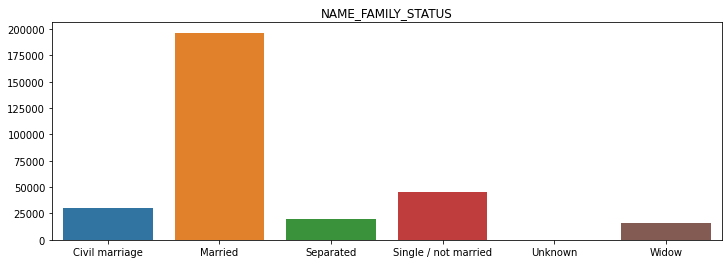

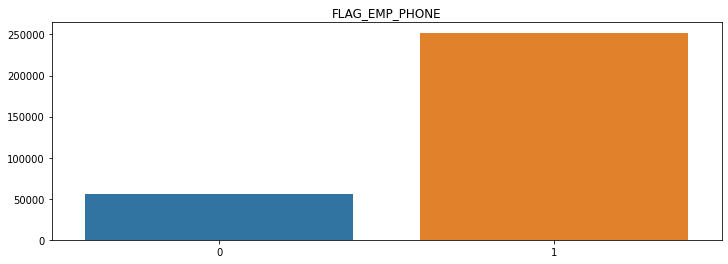

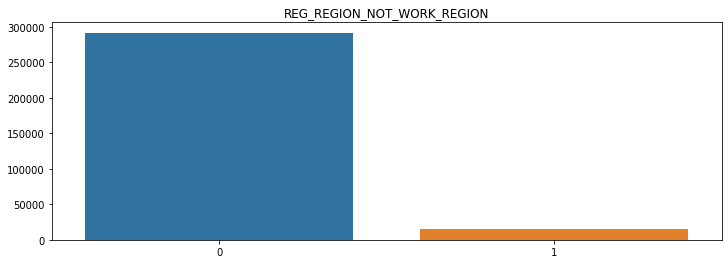

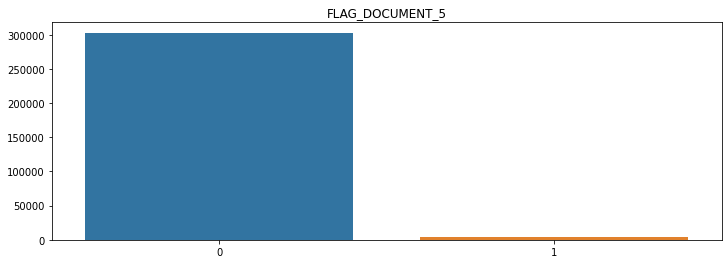

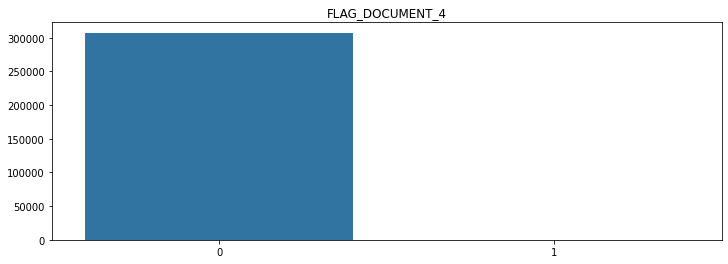

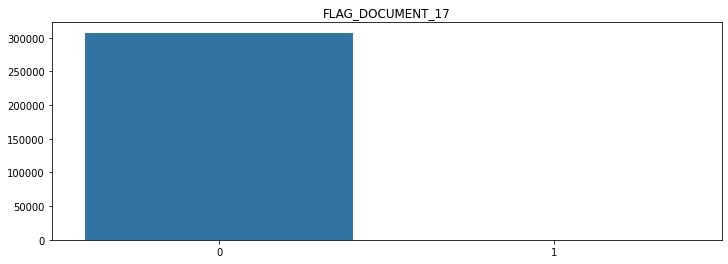

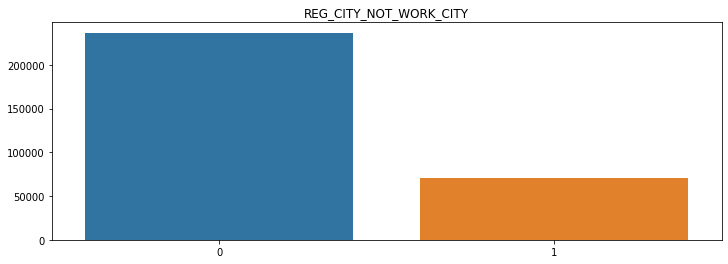

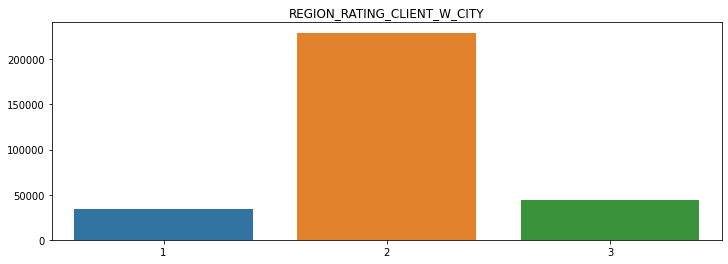

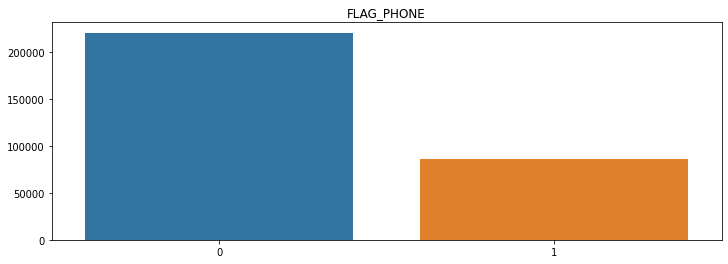

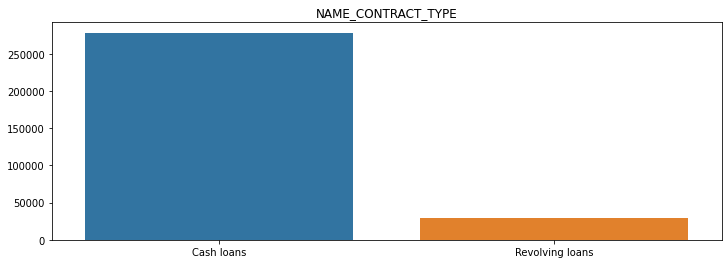

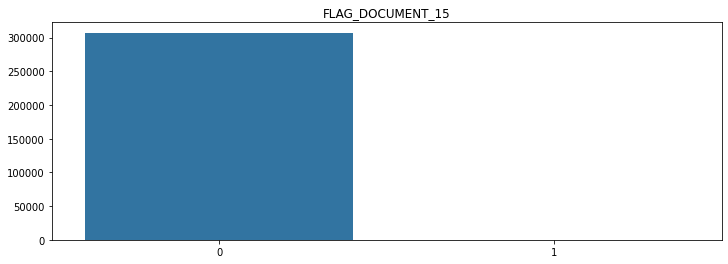

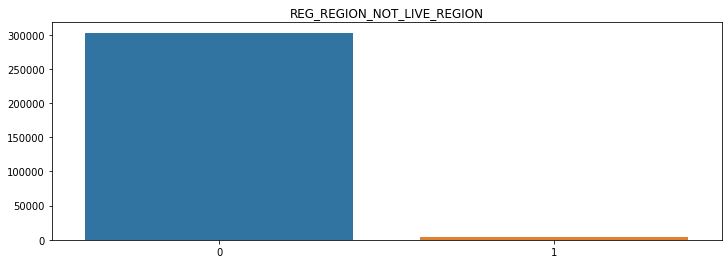

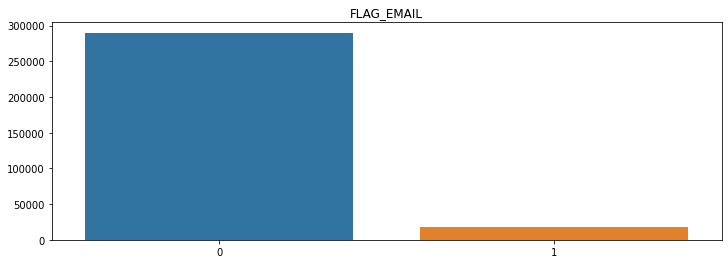

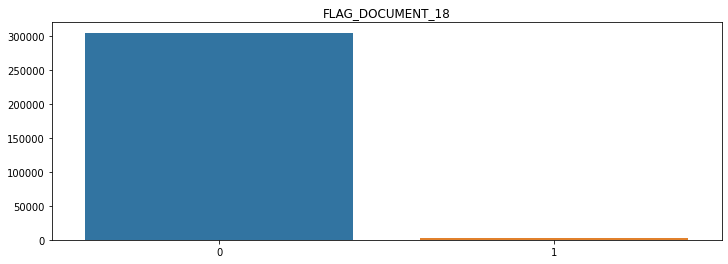

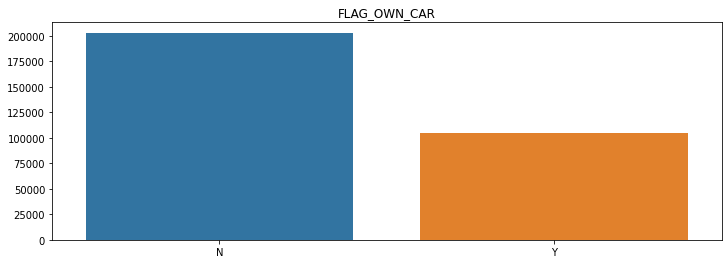

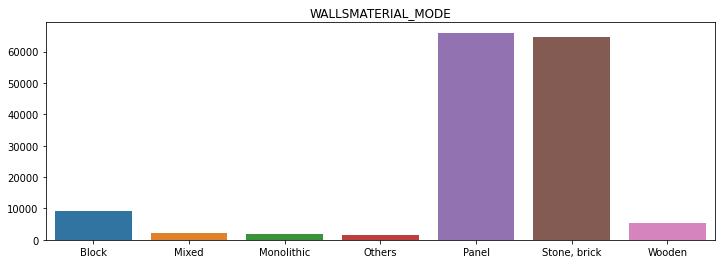

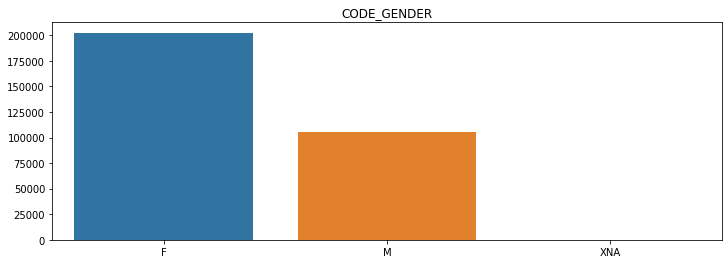

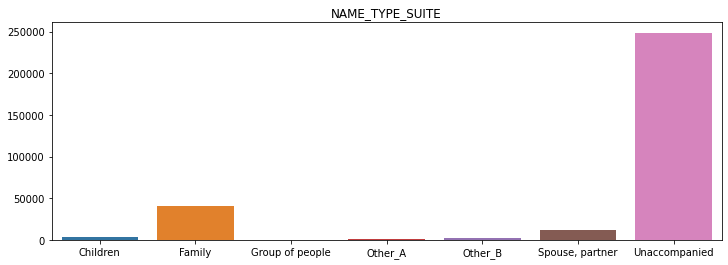

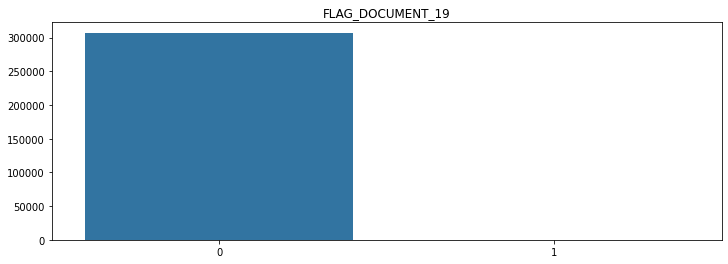

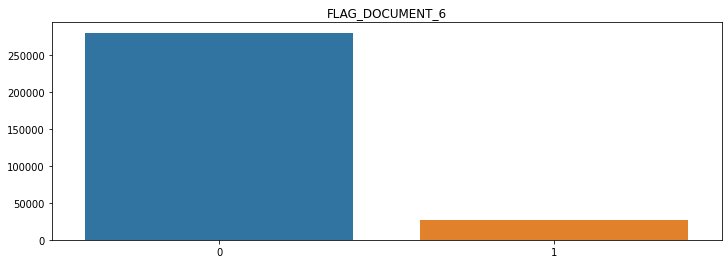

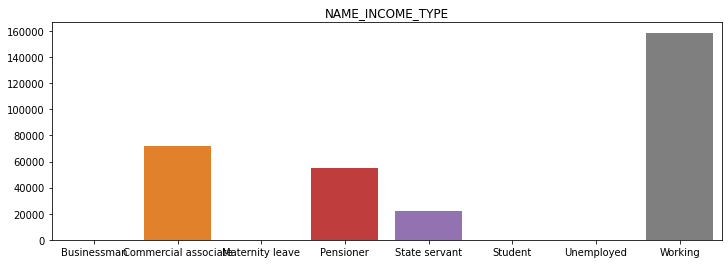

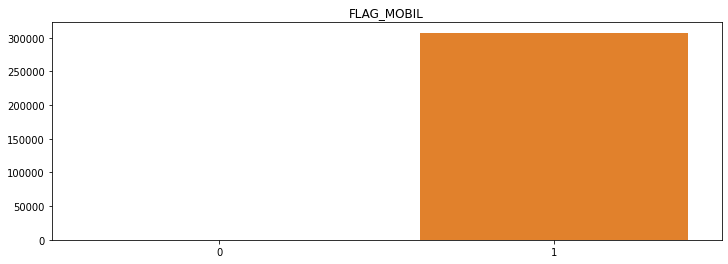

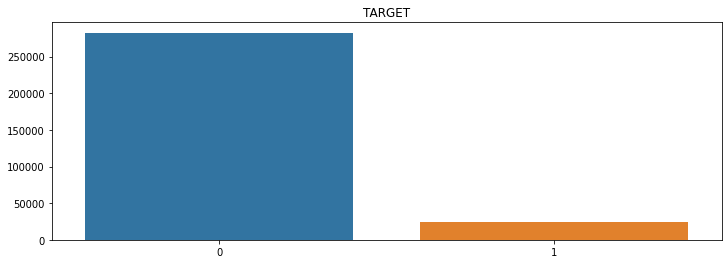

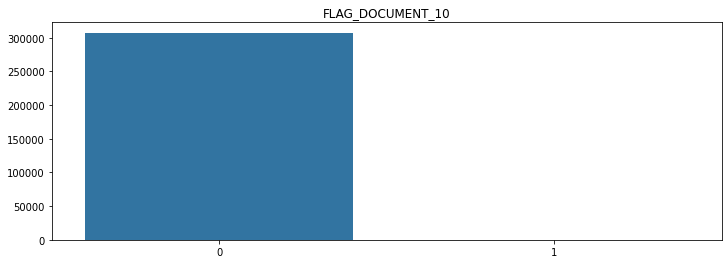

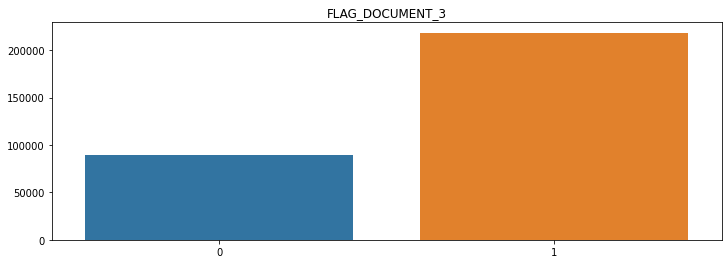

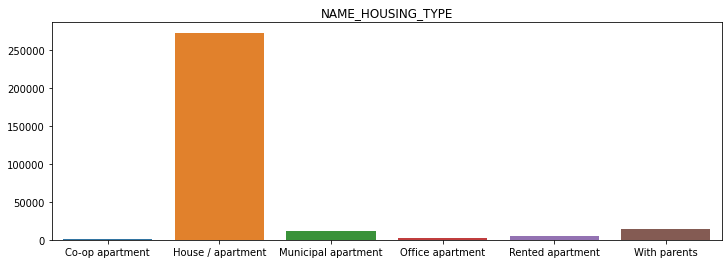

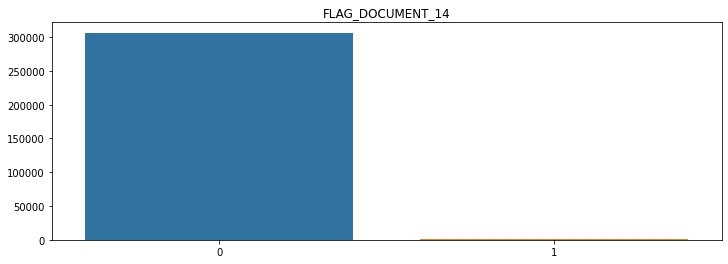

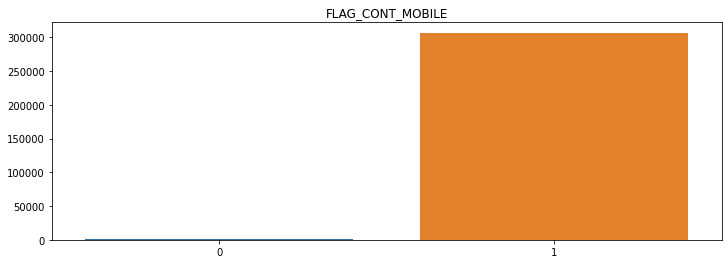

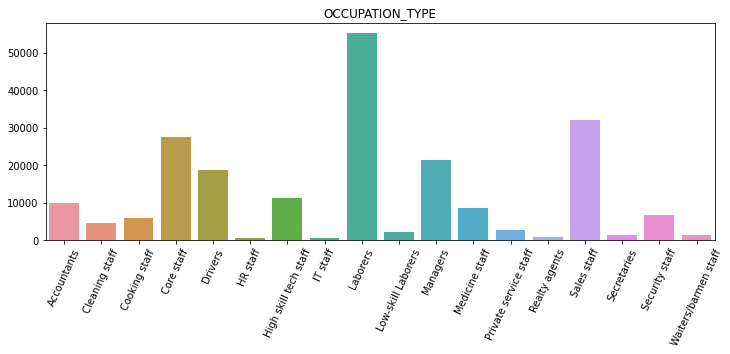

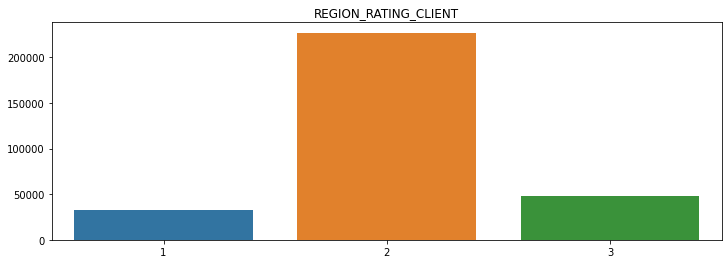

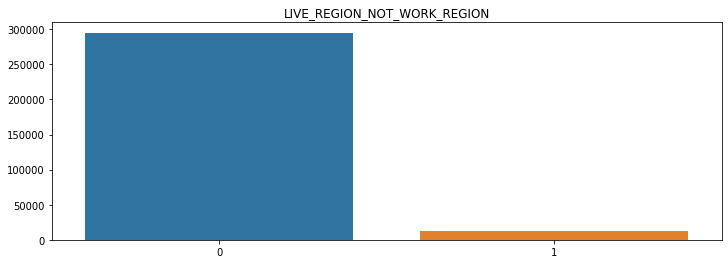

In [10]:
for col in categorical_features:
    x_angle = 0
    if data[col].nunique() > 10:
        x_angle = 65
    plot_categorical(data, col, title=col, x_angle=x_angle)

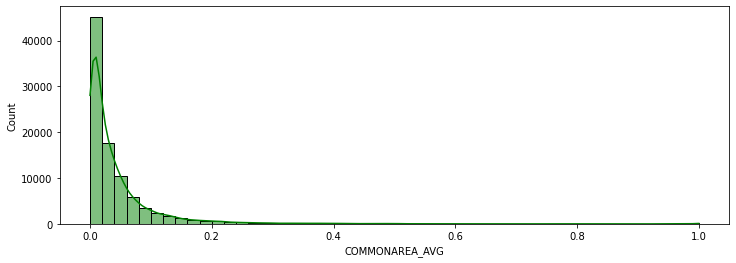

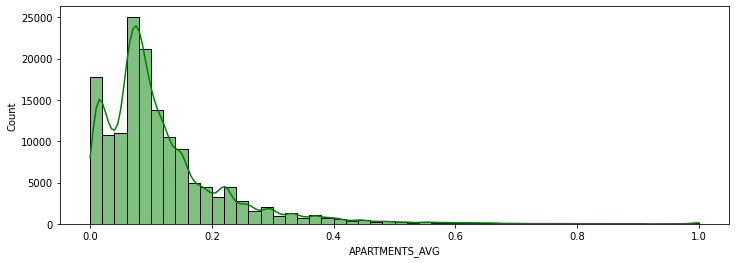

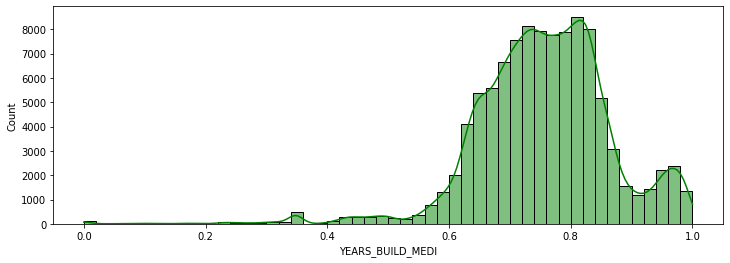

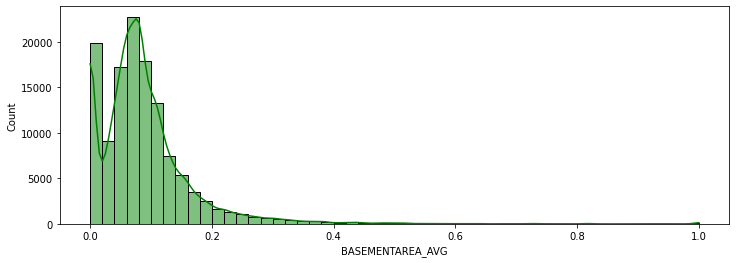

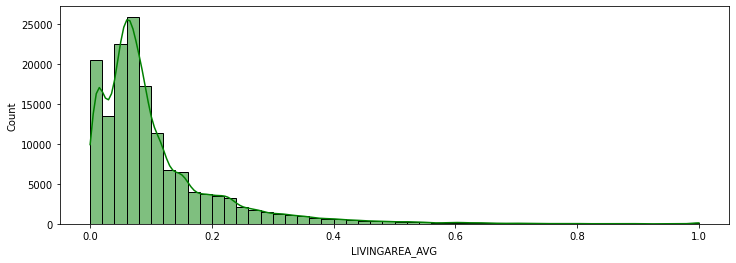

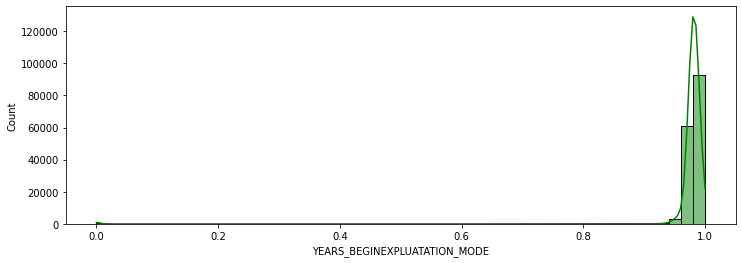

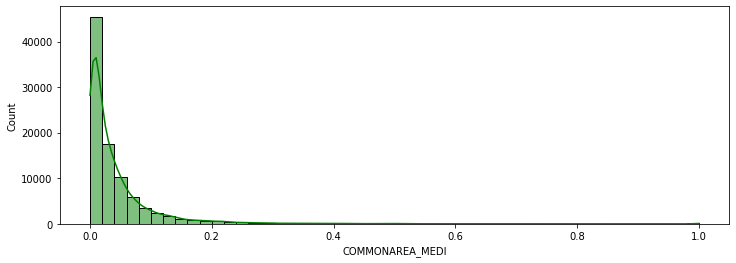

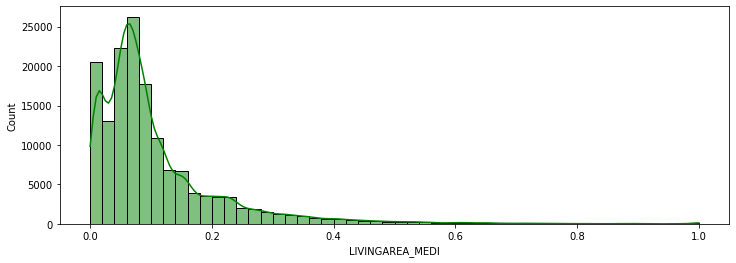

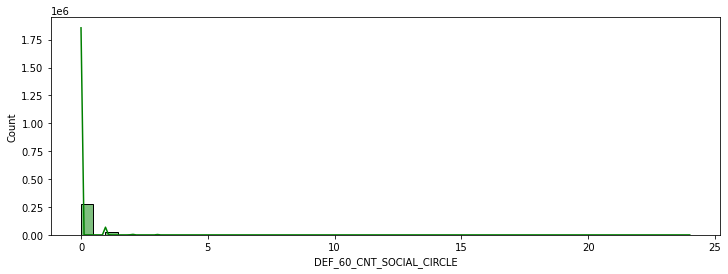

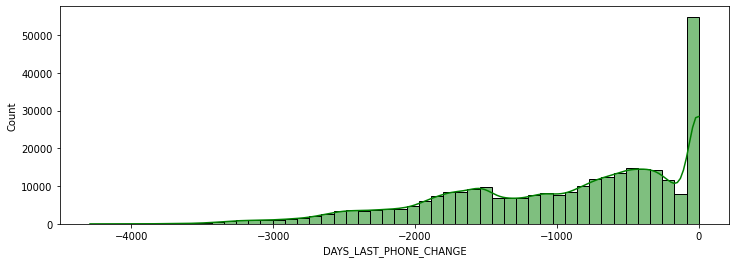

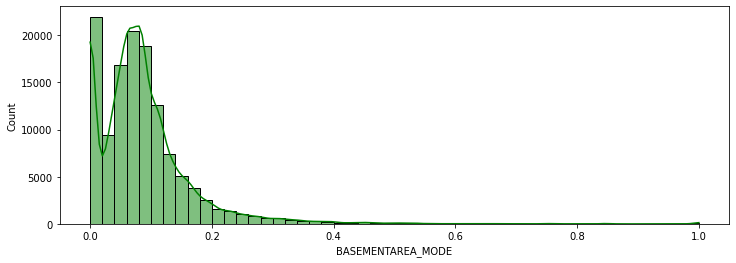

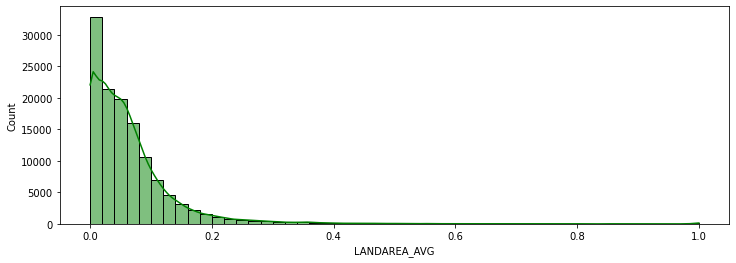

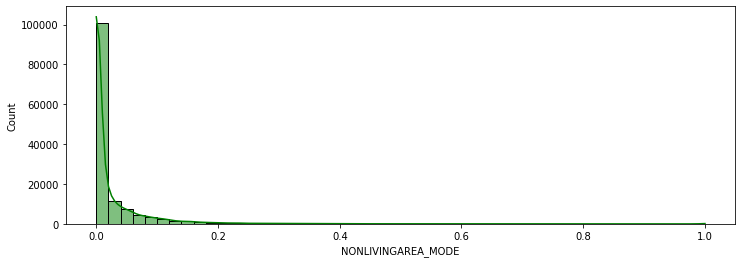

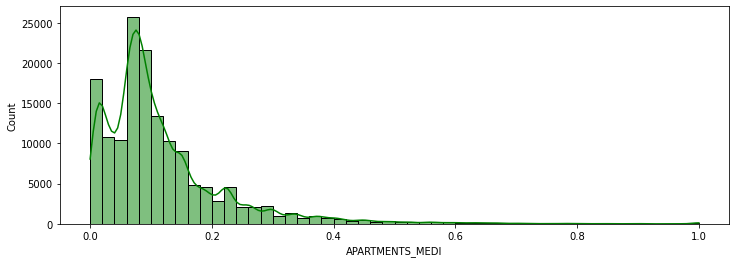

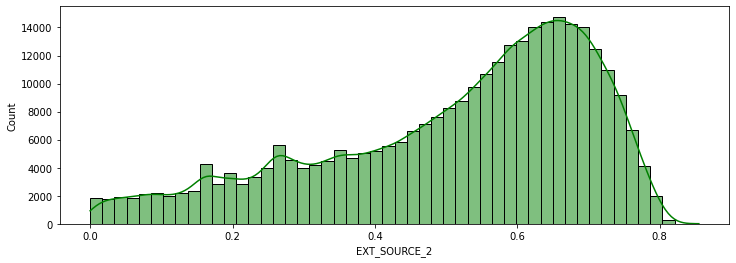

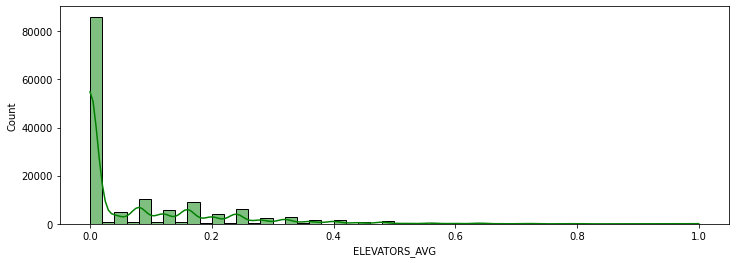

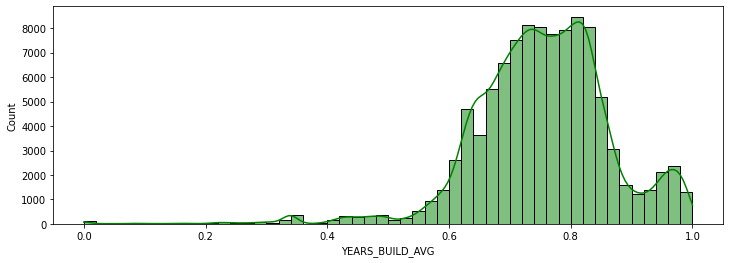

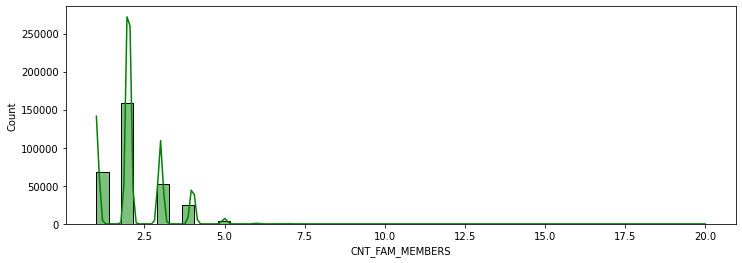

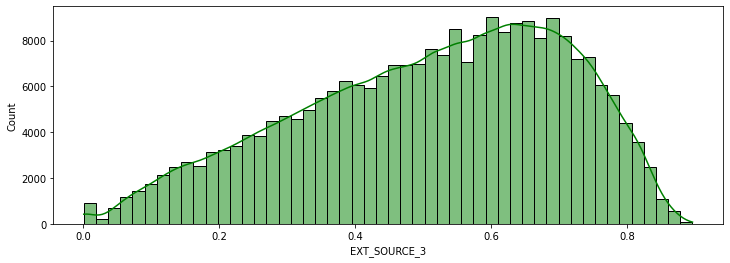

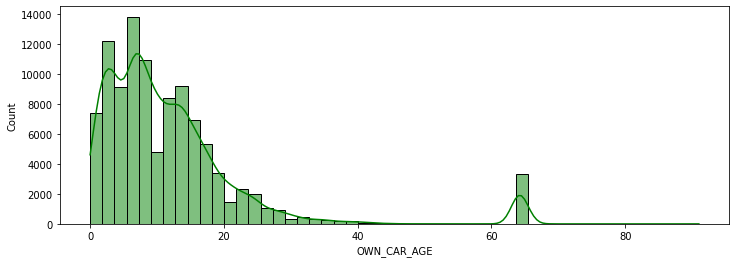

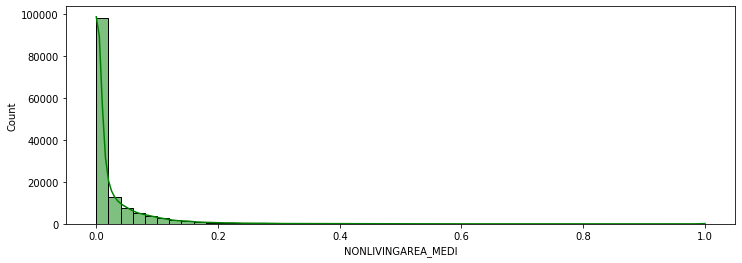

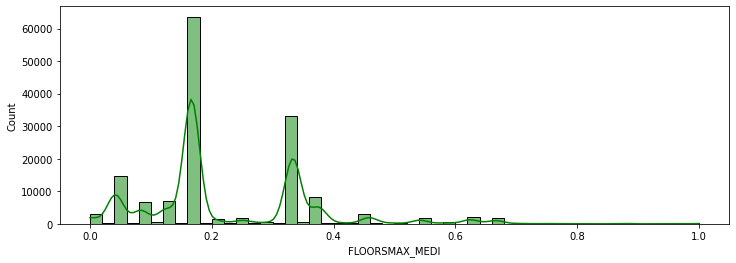

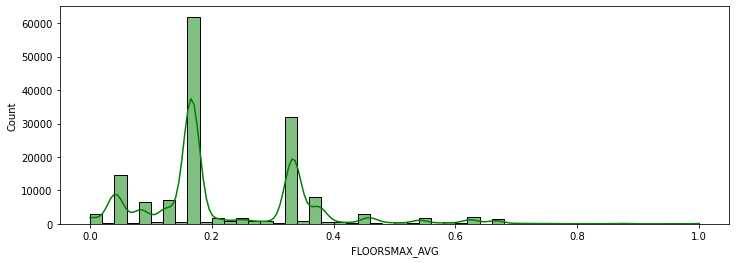

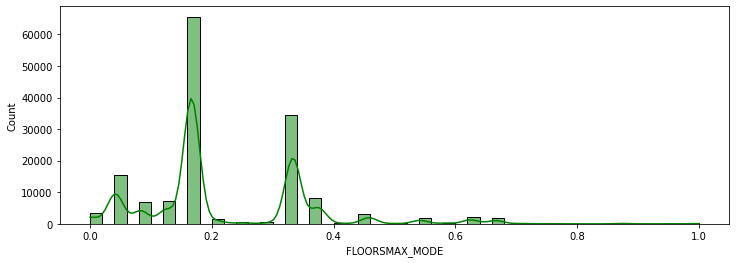

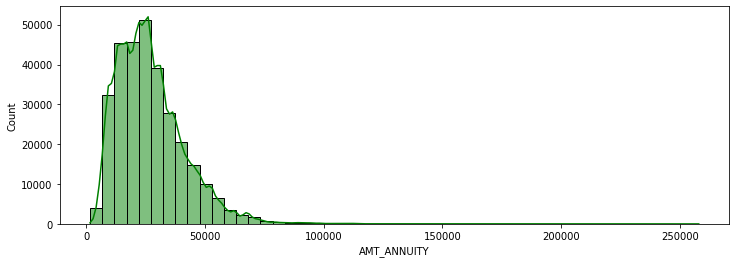

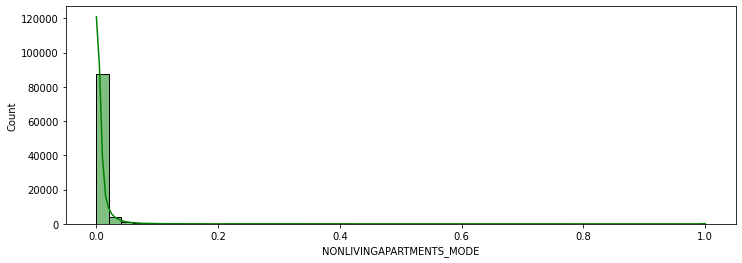

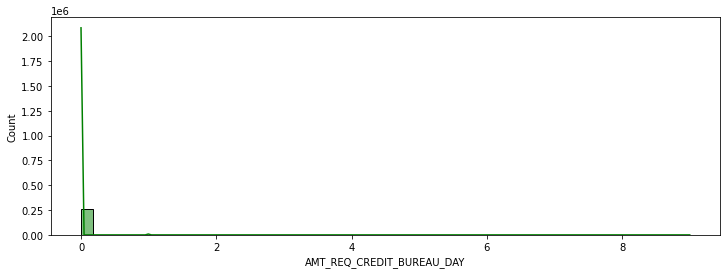

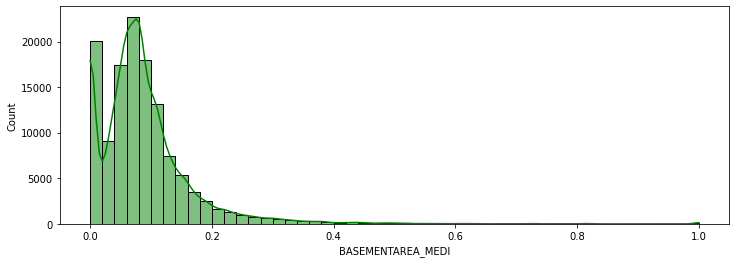

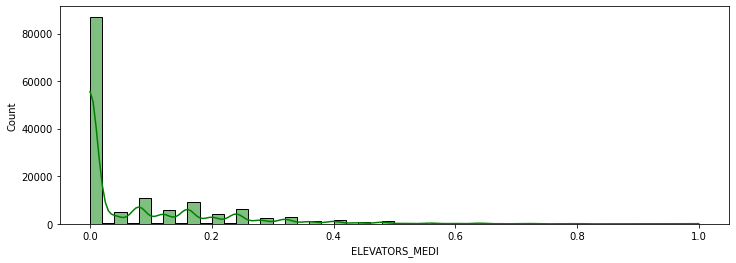

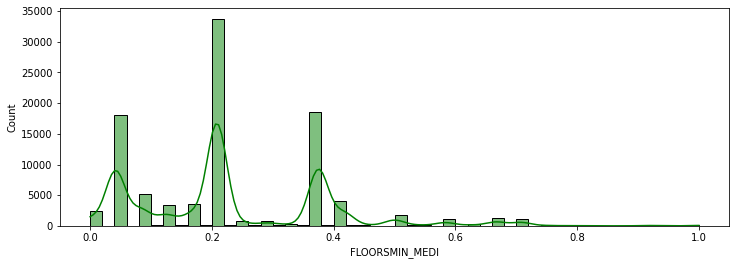

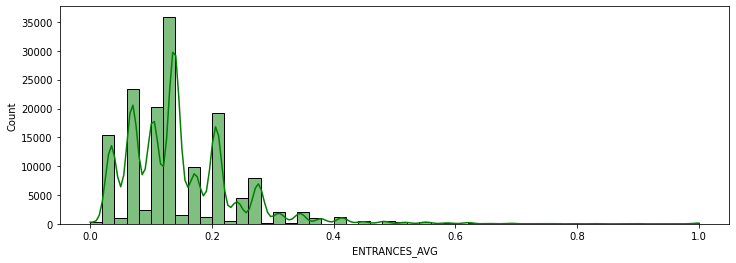

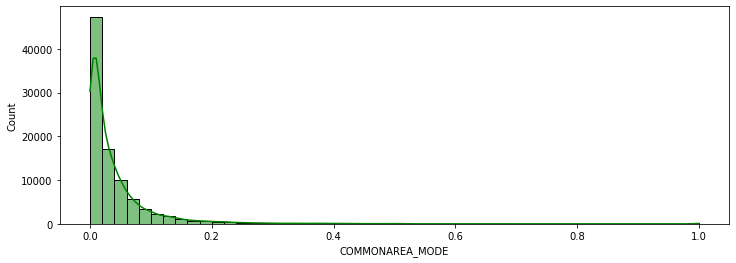

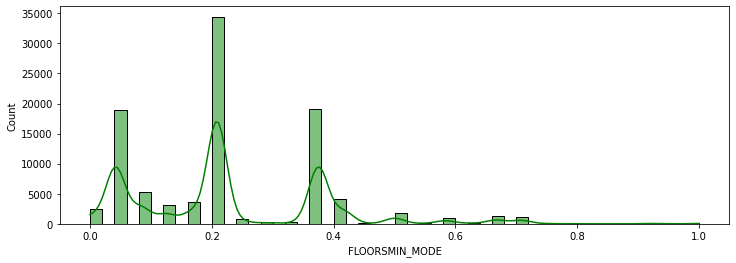

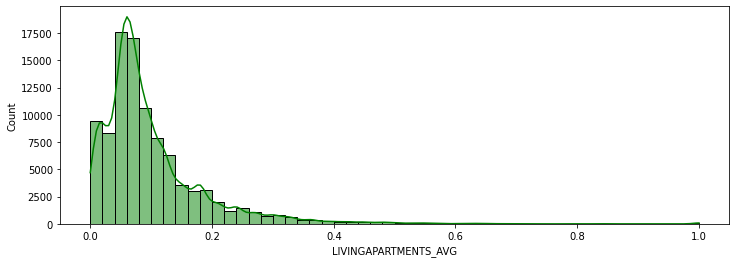

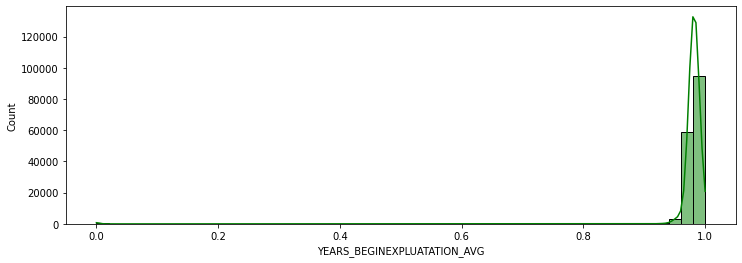

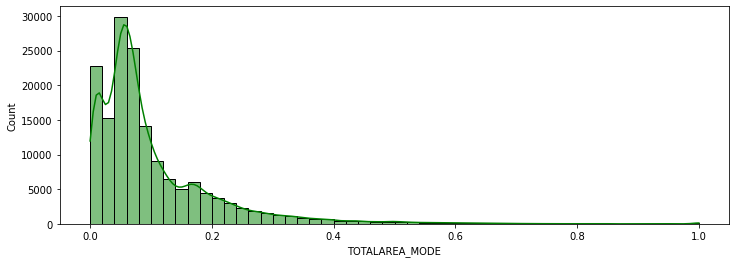

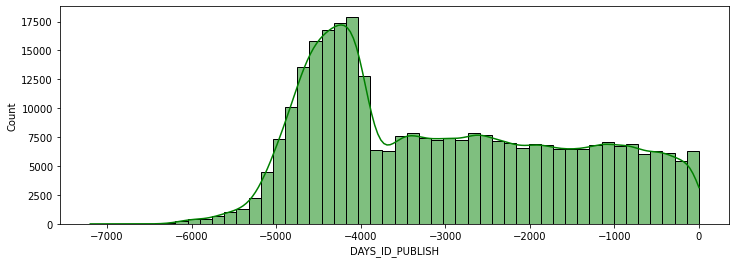

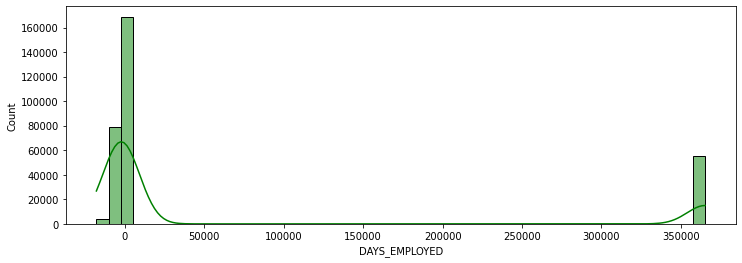

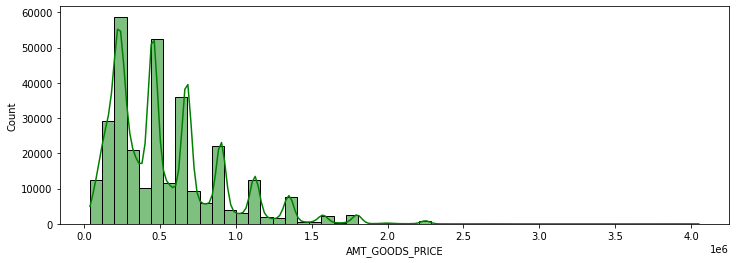

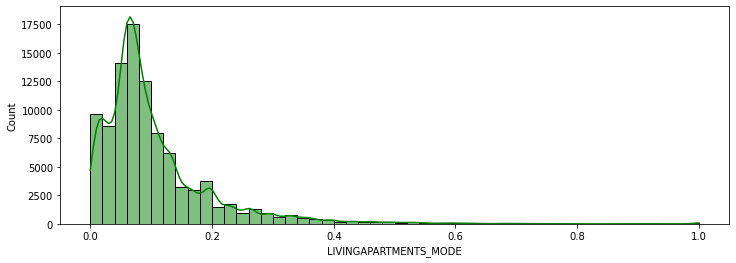

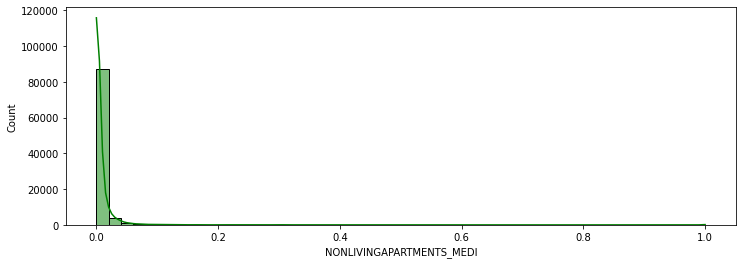

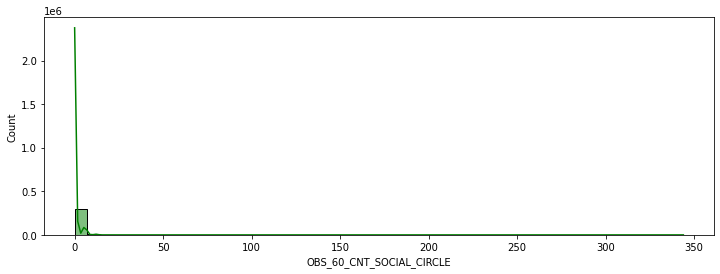

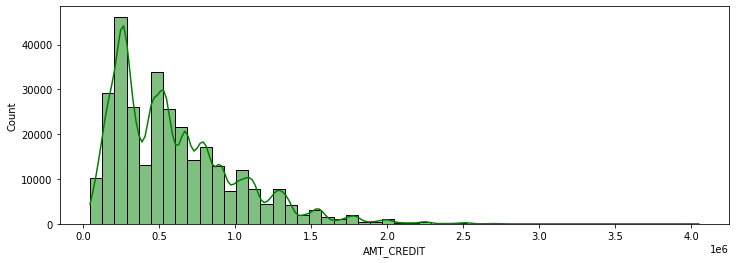

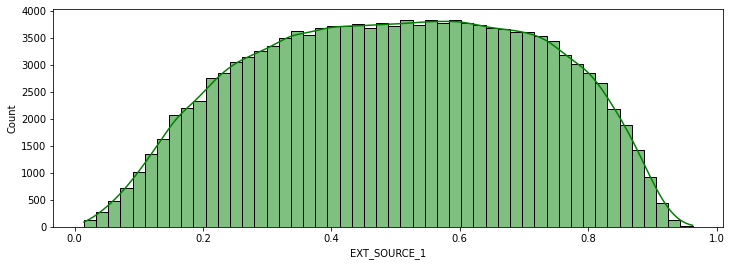

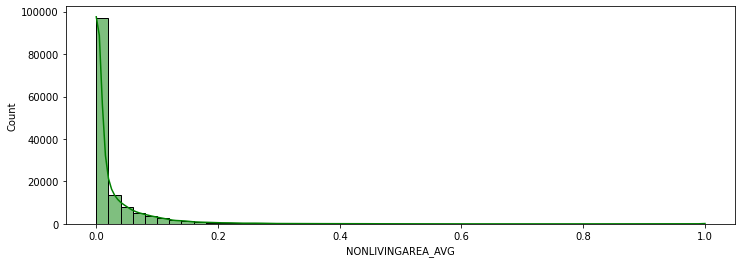

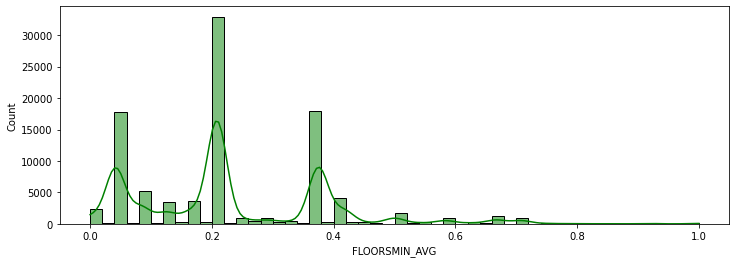

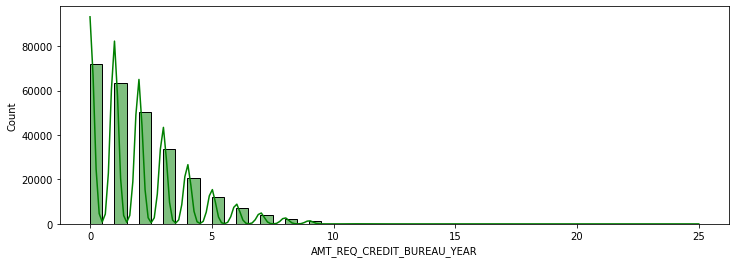

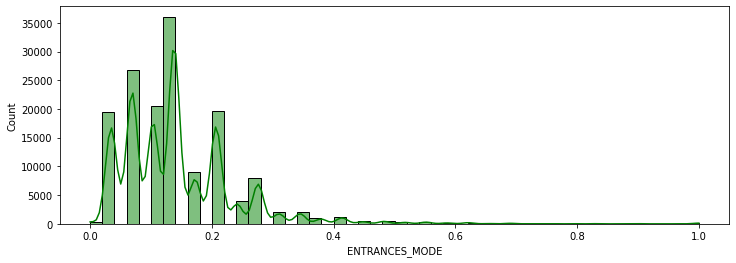

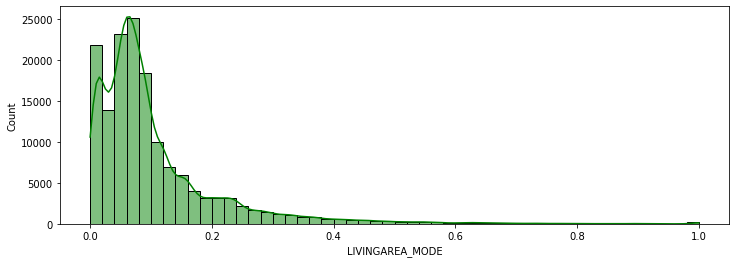

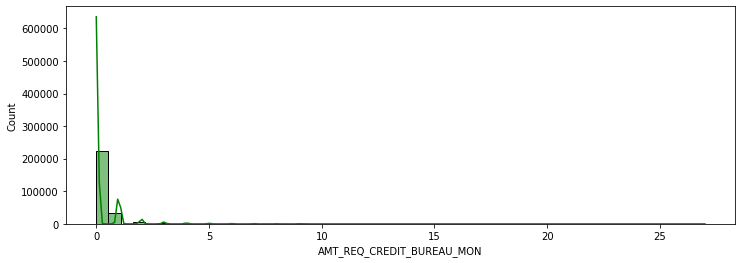

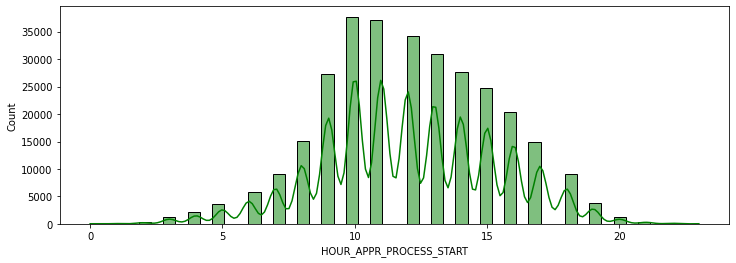

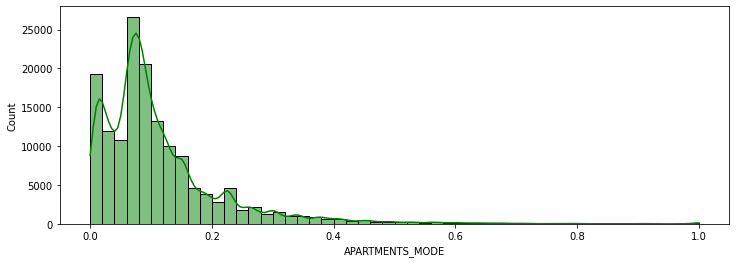

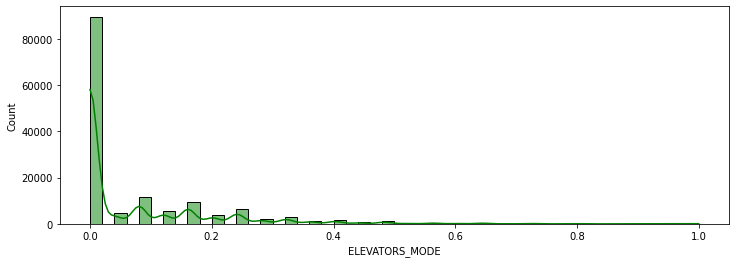

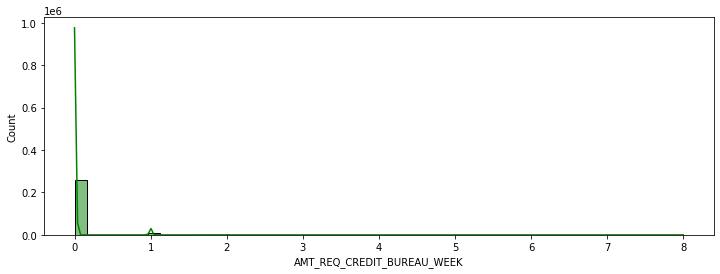

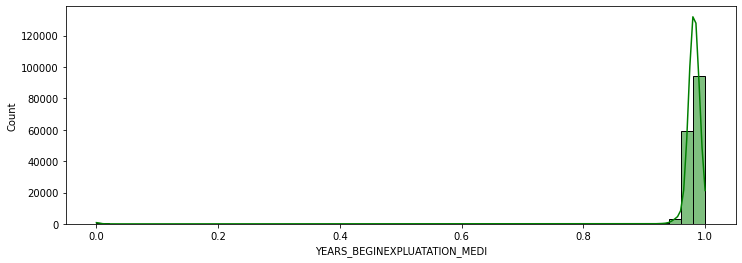

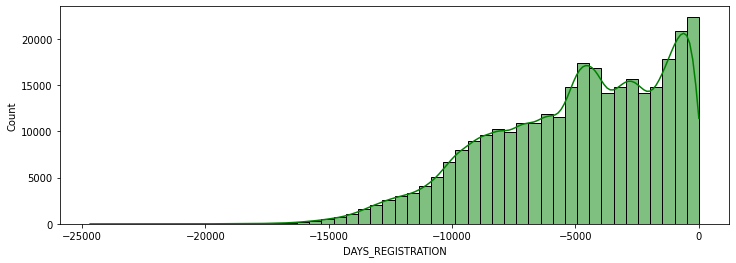

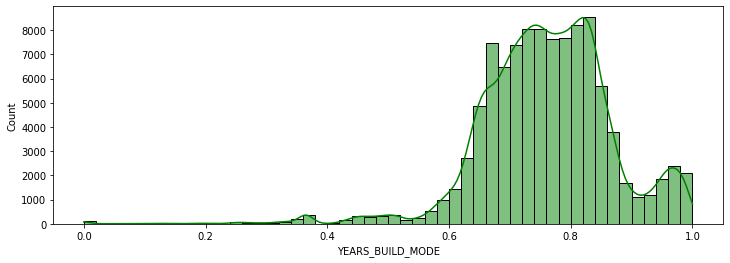

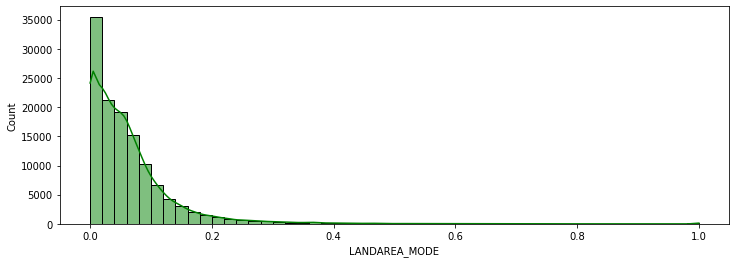

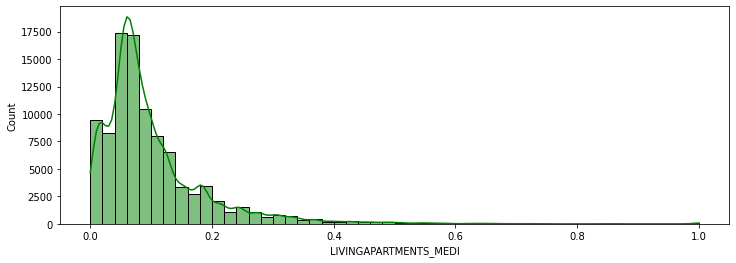

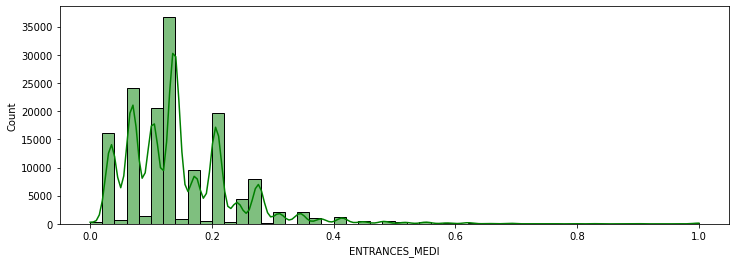

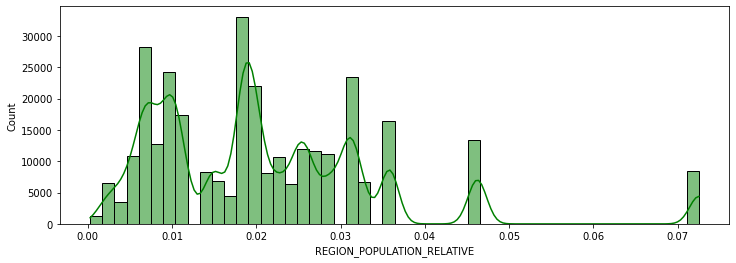

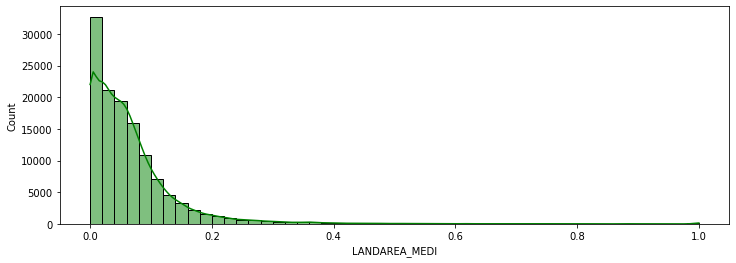

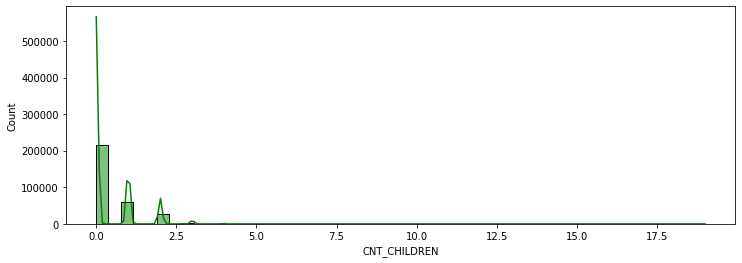

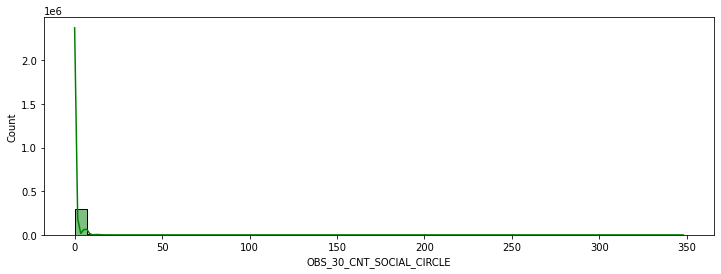

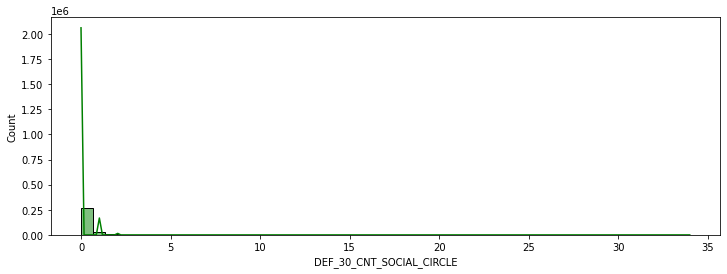

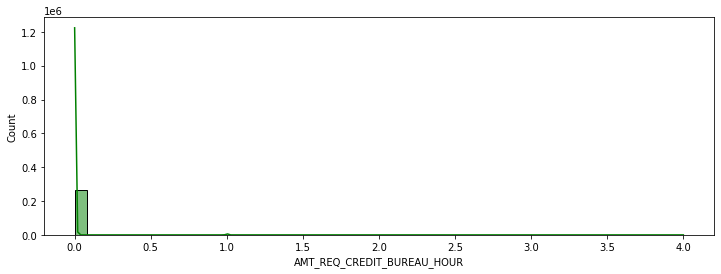

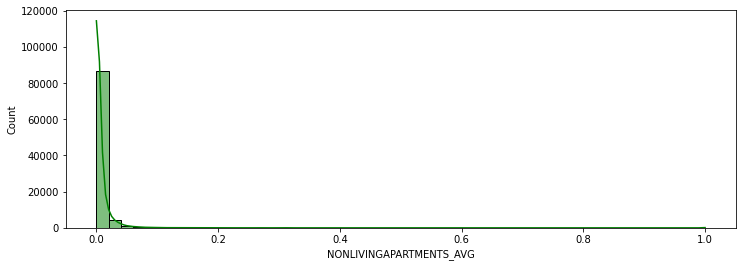

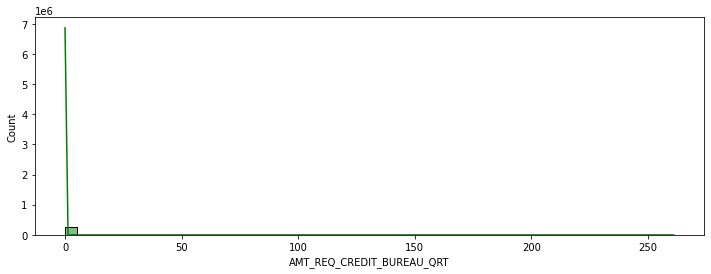

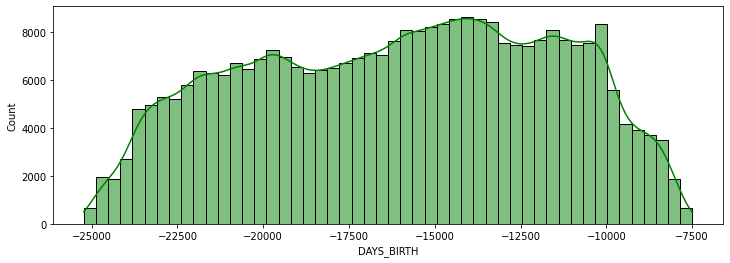

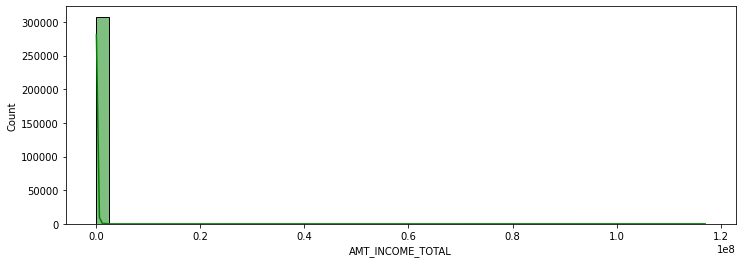

In [11]:
for feature in numerical_features:
    plot_numerical(data, feature)

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


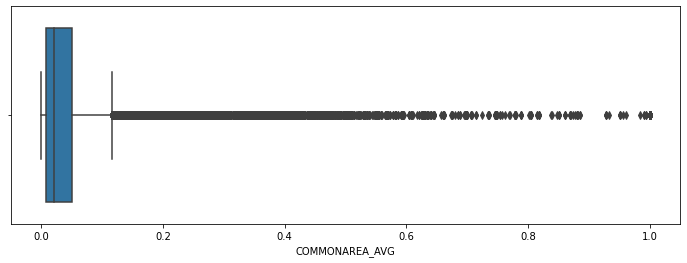

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


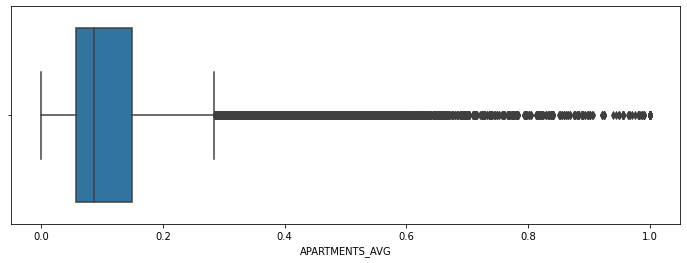

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


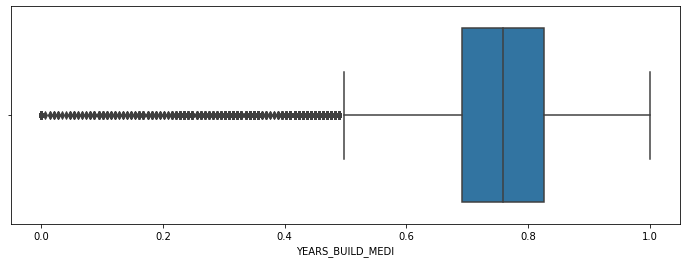

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


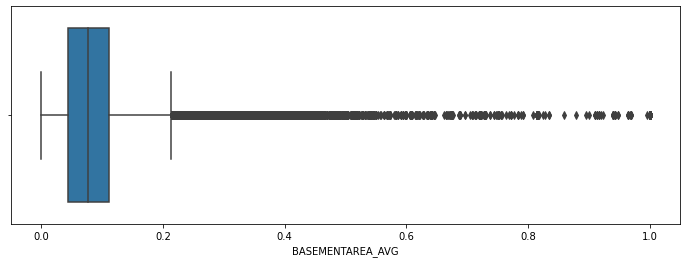

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


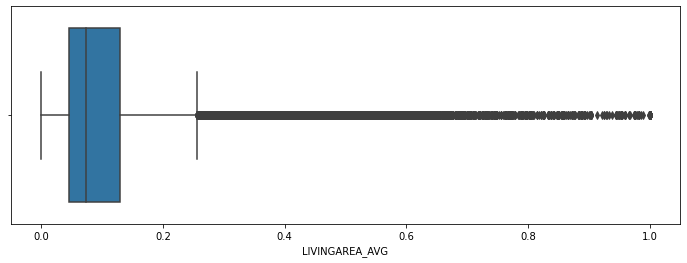

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


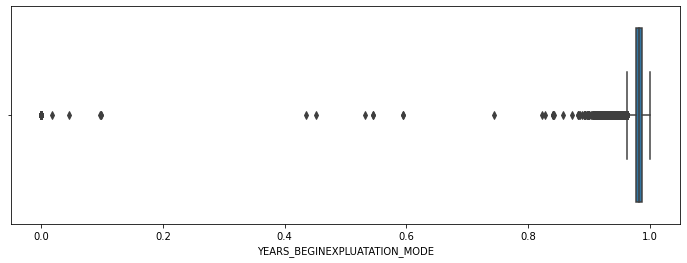

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


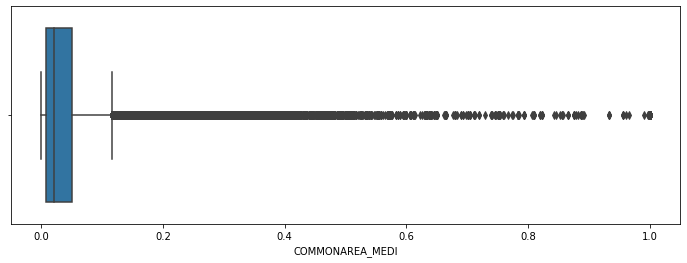

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


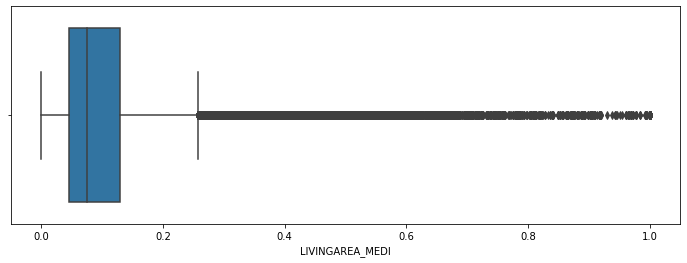

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


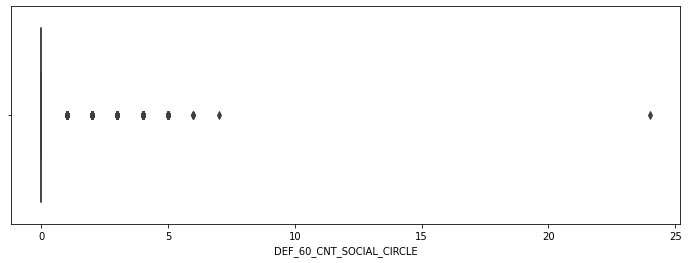

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


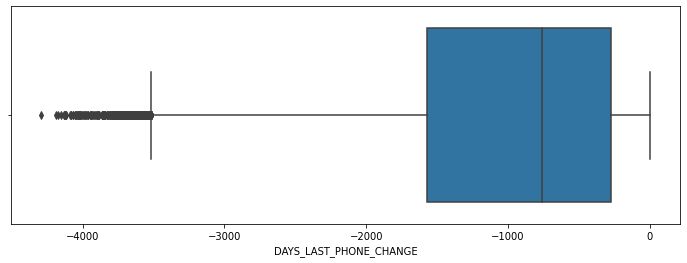

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


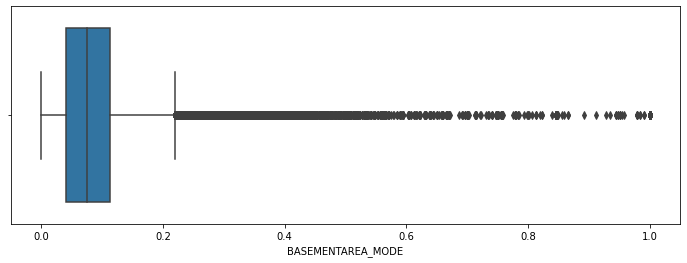

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


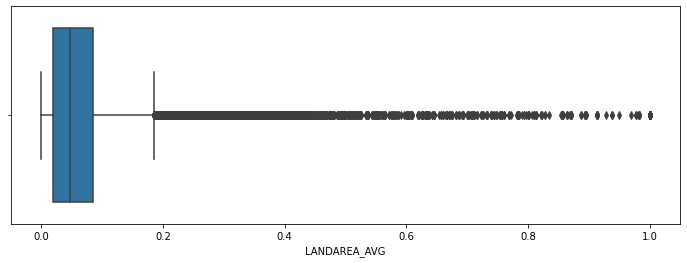

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


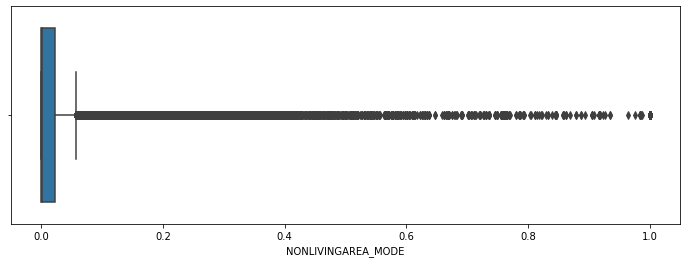

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


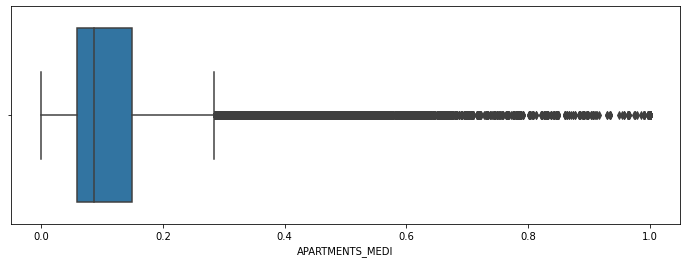

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


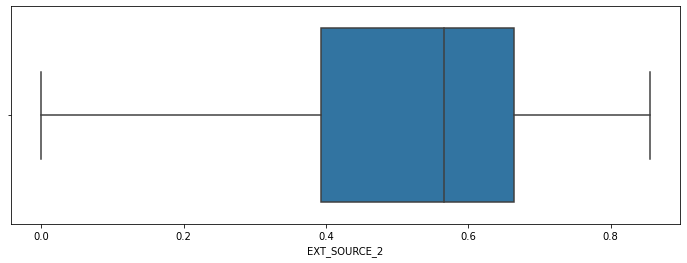

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


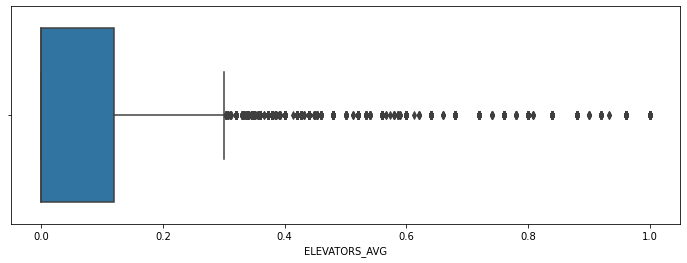

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


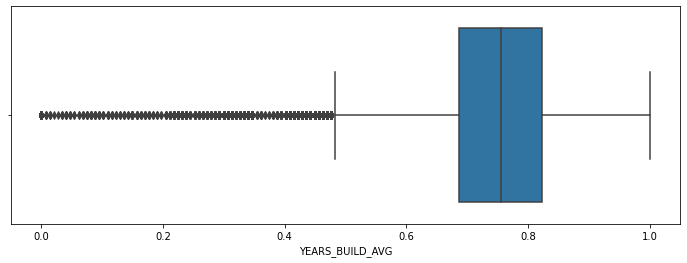

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


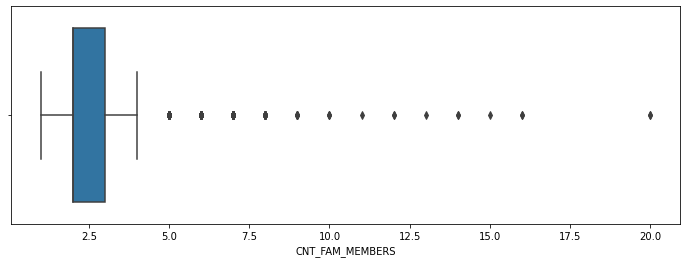

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


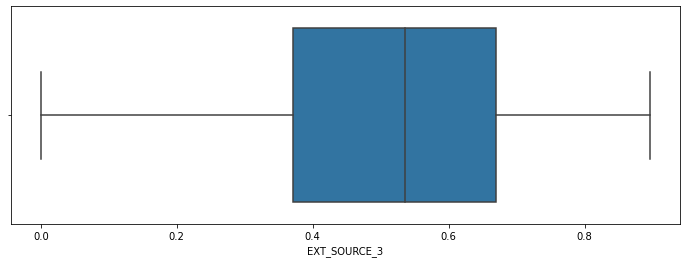

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


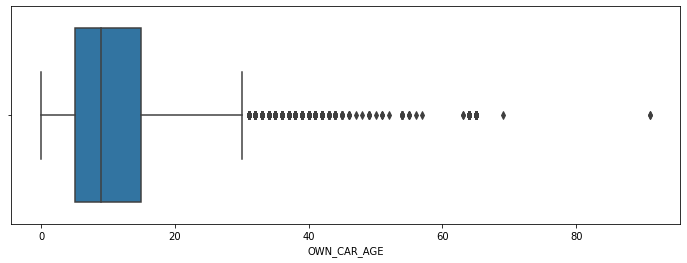

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


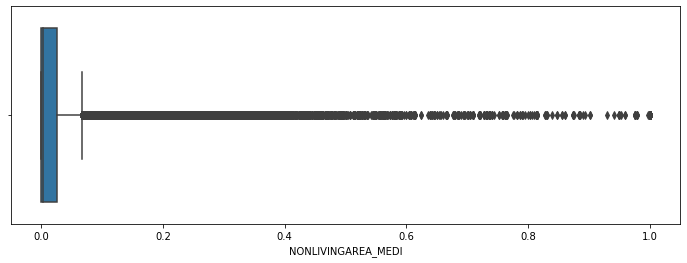

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


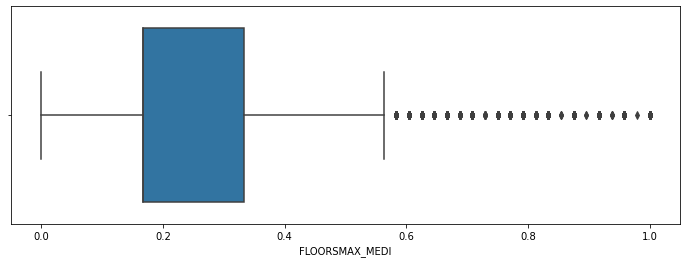

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


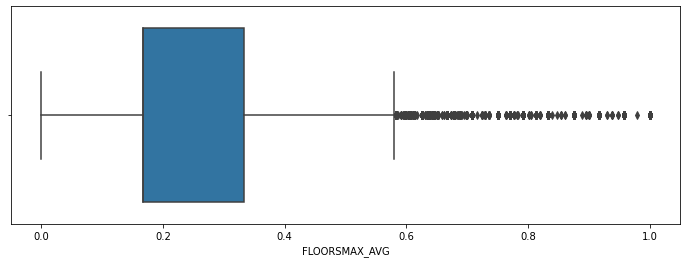

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


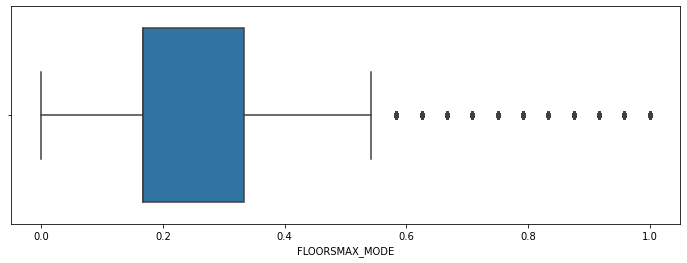

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


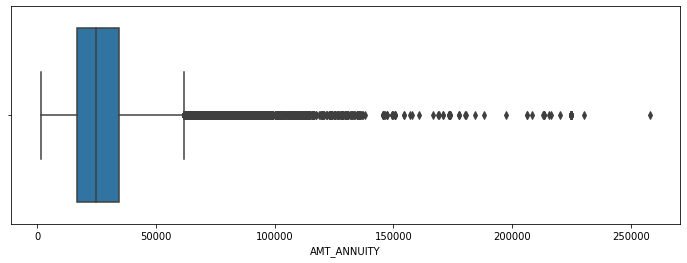

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


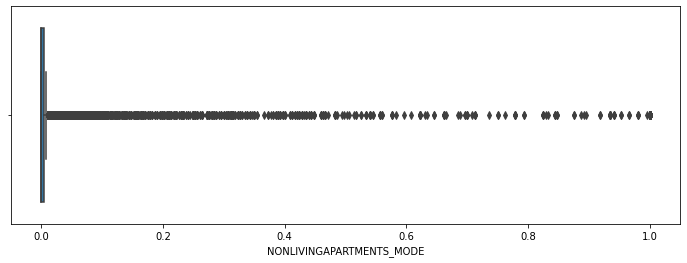

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


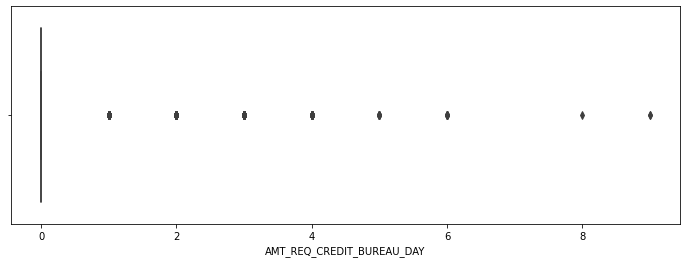

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


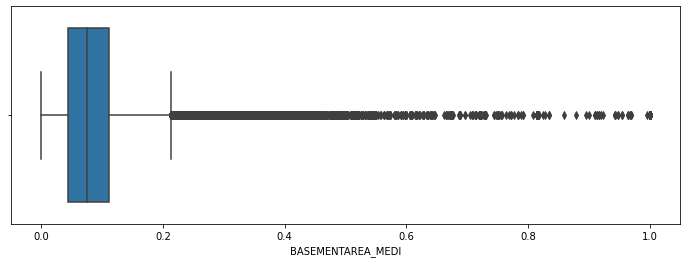

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


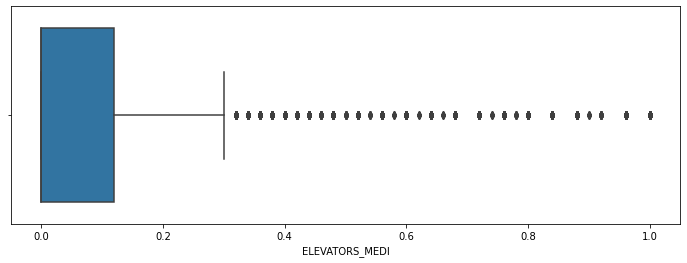

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


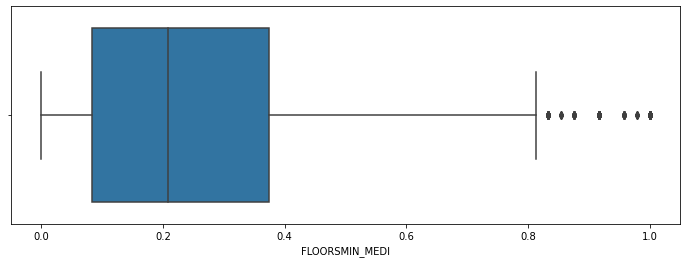

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


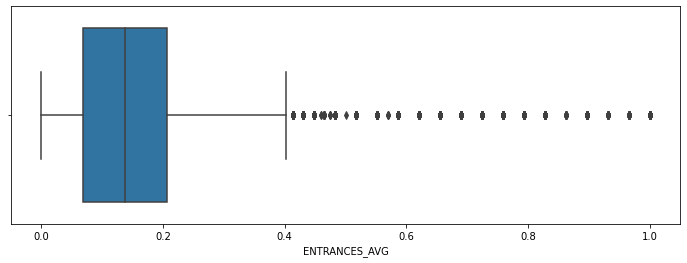

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


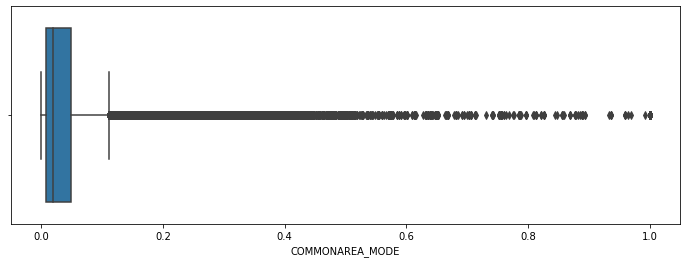

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


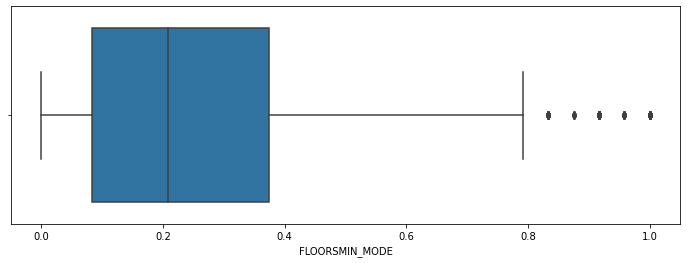

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


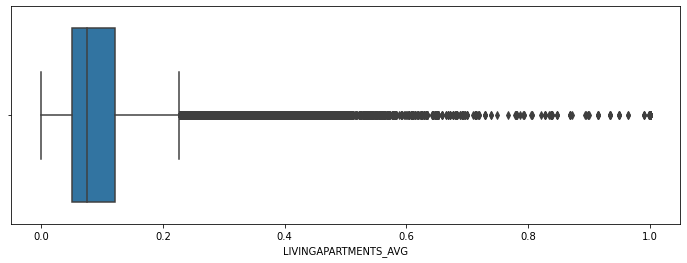

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


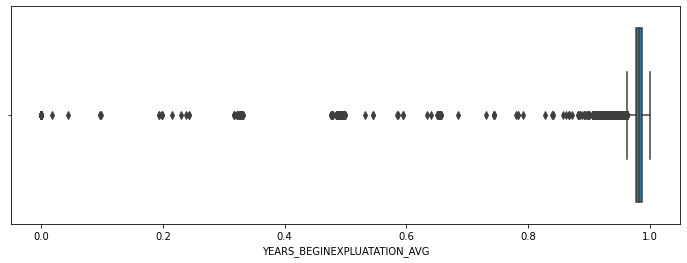

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


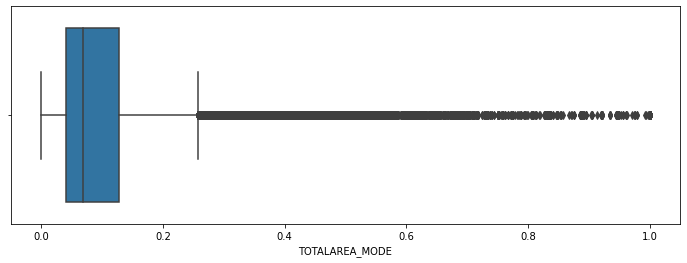

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


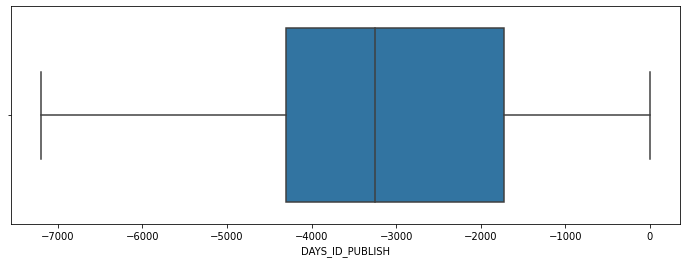

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


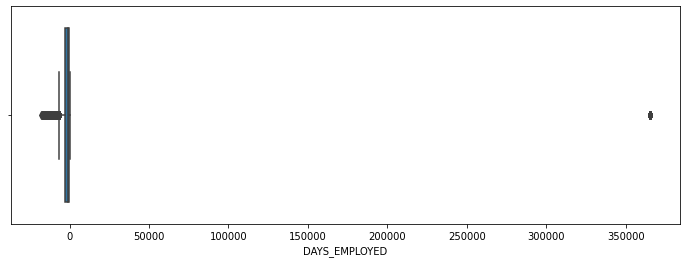

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


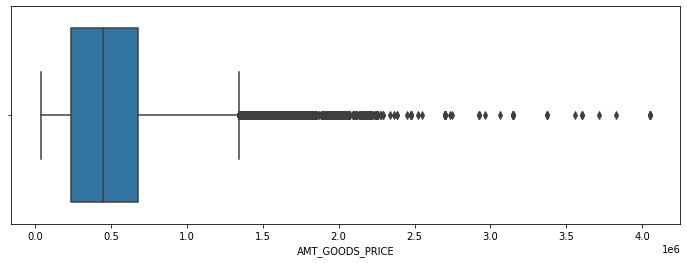

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


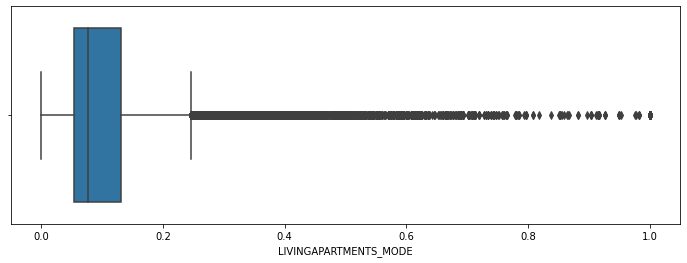

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


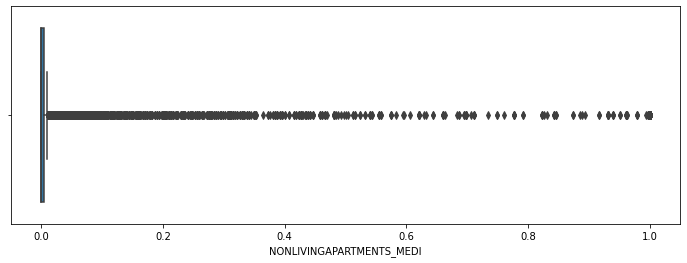

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


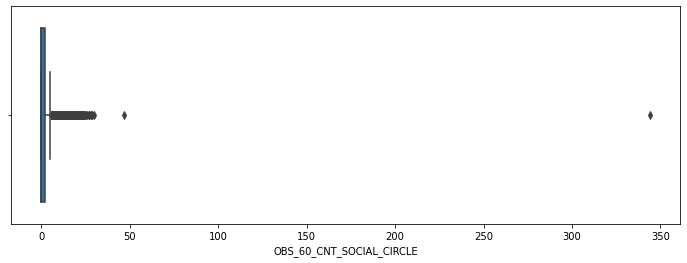

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


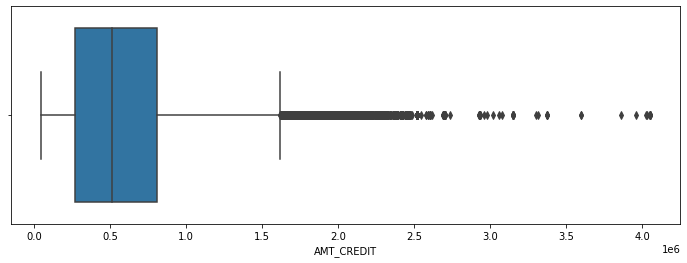

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


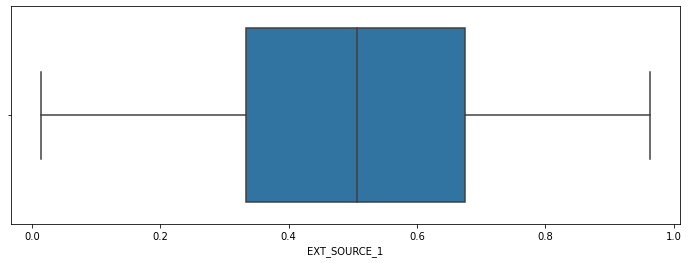

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


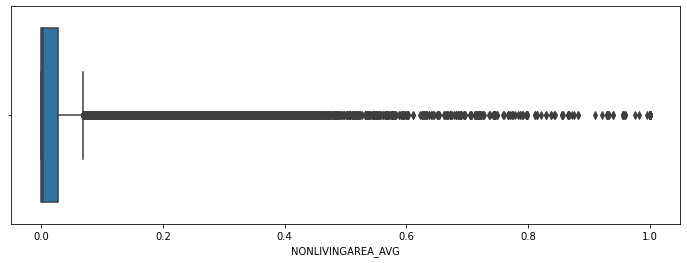

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


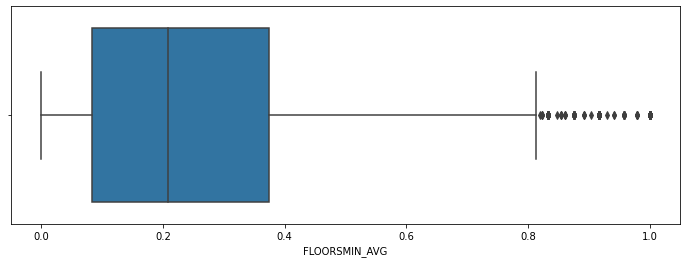

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


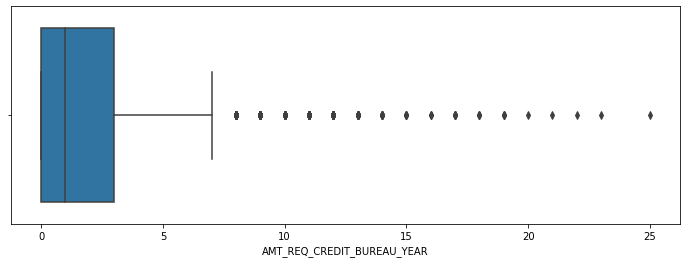

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


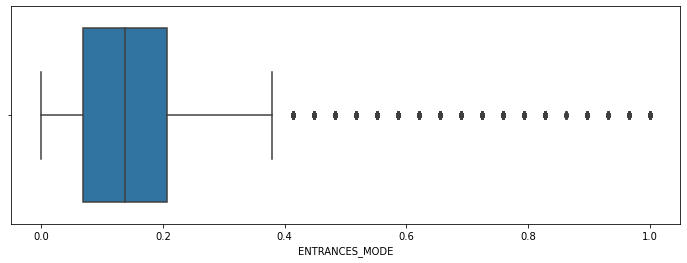

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


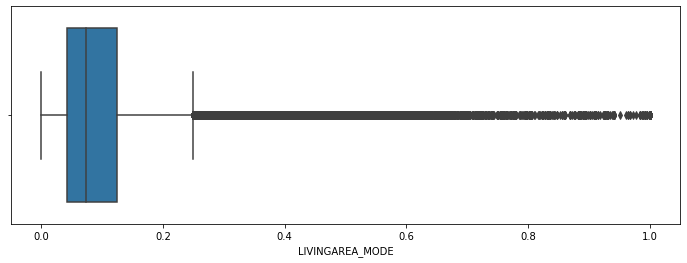

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


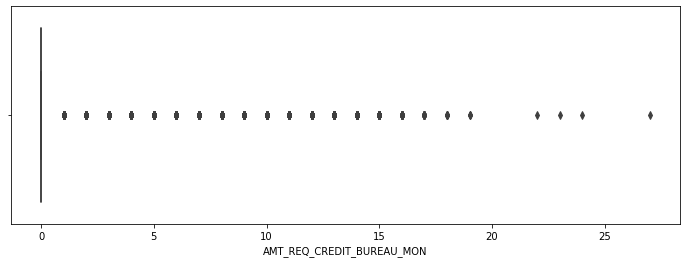

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


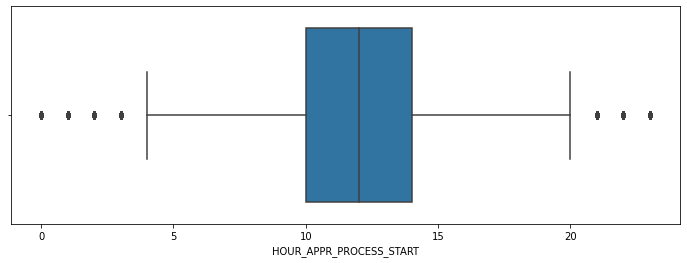

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


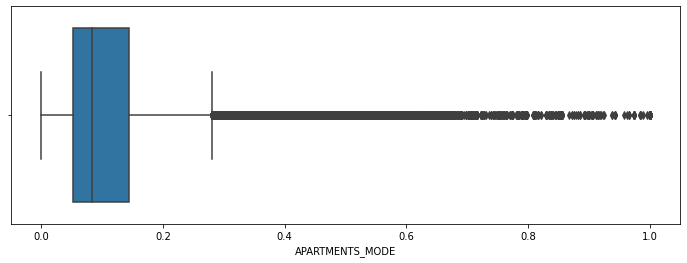

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


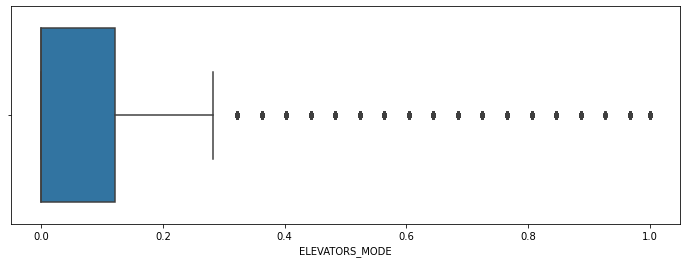

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


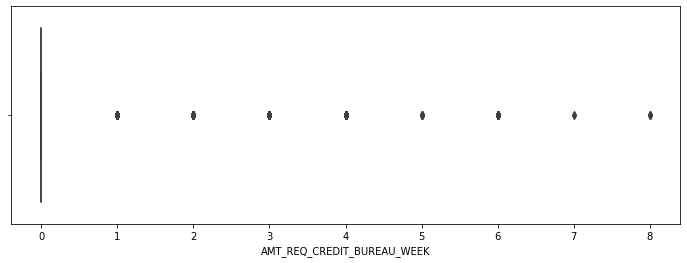

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


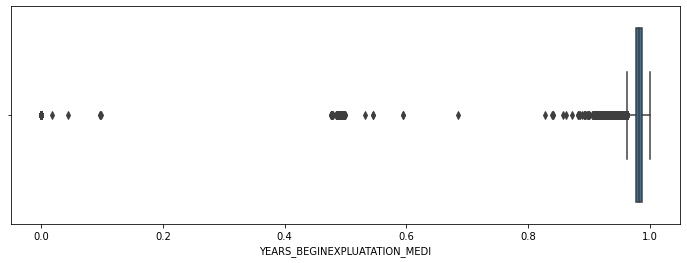

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


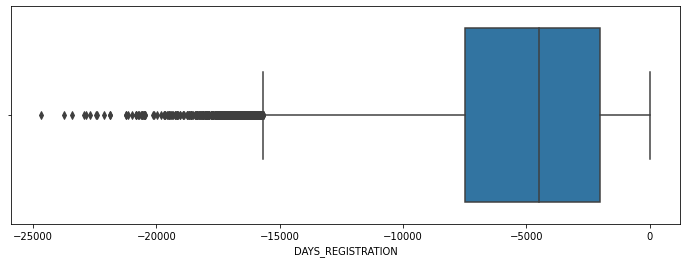

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


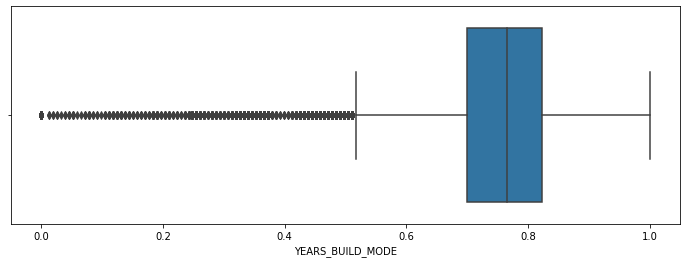

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


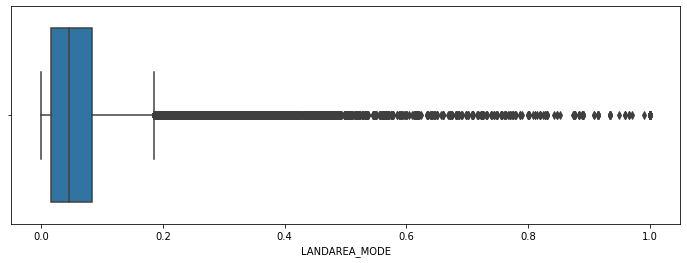

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


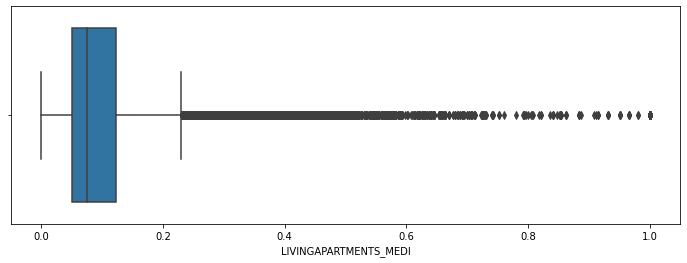

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


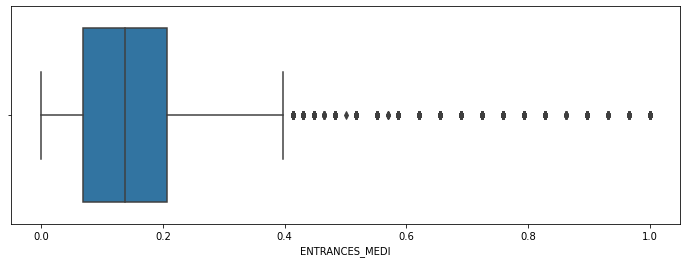

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


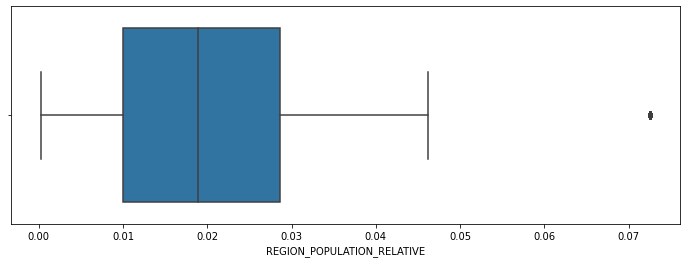

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


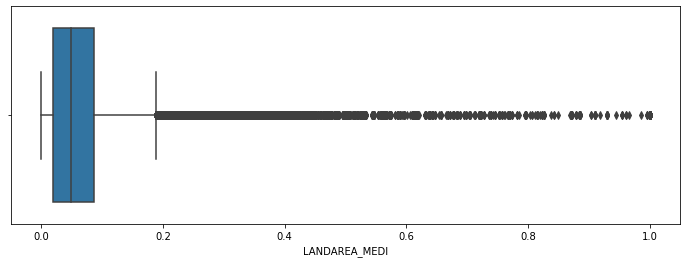

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


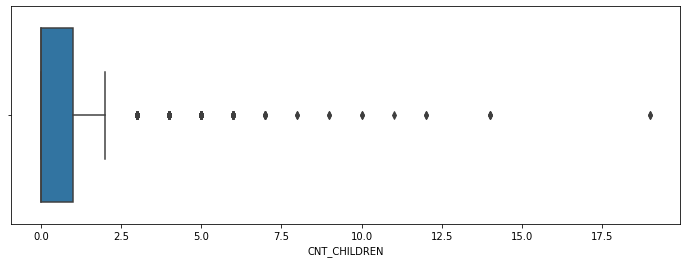

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


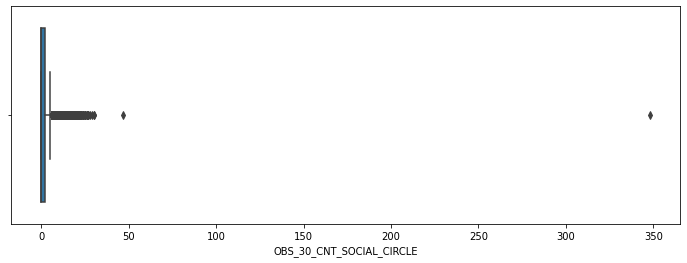

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


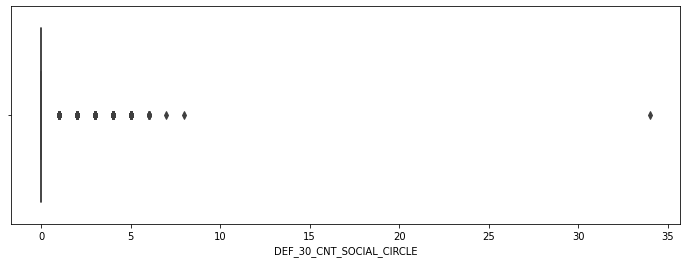

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


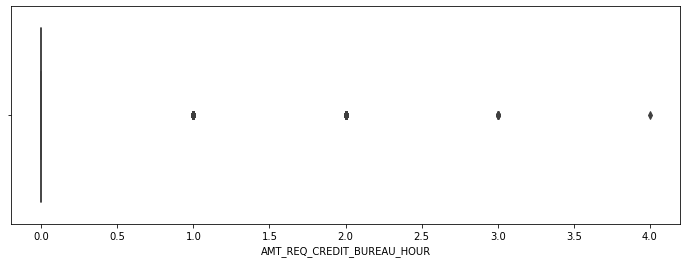

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


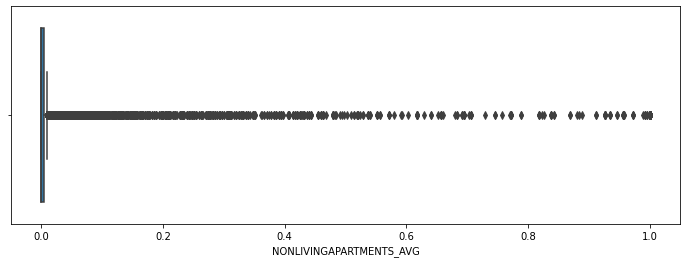

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


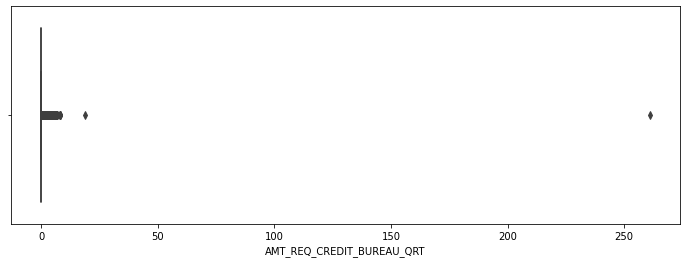

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


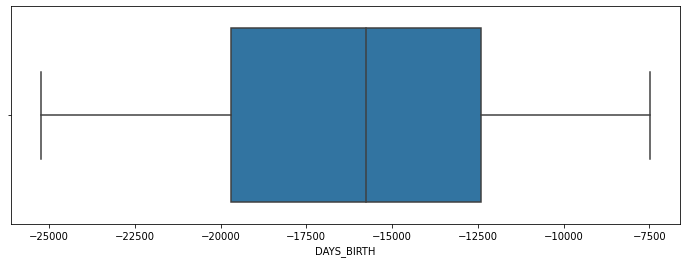

c:\users\wykyee\pycharmprojects\ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


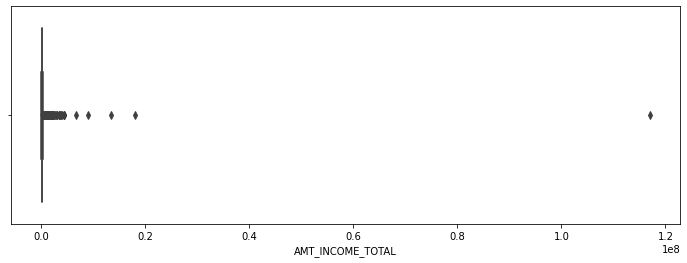

In [12]:
for feature in numerical_features:
    plot_numerical(data, feature, type_='box')

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [14]:
for col in numerical_features:
    data[col].fillna(value=data[col].mean(), inplace=True)

In [15]:
train_features = data[numerical_features]
train_features

,COMMONAREA_AVG,APARTMENTS_AVG,YEARS_BUILD_MEDI,BASEMENTAREA_AVG,LIVINGAREA_AVG,YEARS_BEGINEXPLUATATION_MODE,COMMONAREA_MEDI,LIVINGAREA_MEDI,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,BASEMENTAREA_MODE,LANDAREA_AVG,NONLIVINGAREA_MODE,APARTMENTS_MEDI,EXT_SOURCE_2,ELEVATORS_AVG,YEARS_BUILD_AVG,CNT_FAM_MEMBERS,EXT_SOURCE_3,OWN_CAR_AGE,NONLIVINGAREA_MEDI,FLOORSMAX_MEDI,FLOORSMAX_AVG,FLOORSMAX_MODE,AMT_ANNUITY,NONLIVINGAPARTMENTS_MODE,AMT_REQ_CREDIT_BUREAU_DAY,BASEMENTAREA_MEDI,ELEVATORS_MEDI,FLOORSMIN_MEDI,ENTRANCES_AVG,COMMONAREA_MODE,FLOORSMIN_MODE,LIVINGAPARTMENTS_AVG,YEARS_BEGINEXPLUATATION_AVG,TOTALAREA_MODE,DAYS_ID_PUBLISH,DAYS_EMPLOYED,AMT_GOODS_PRICE,LIVINGAPARTMENTS_MODE,NONLIVINGAPARTMENTS_MEDI,OBS_60_CNT_SOCIAL_CIRCLE,AMT_CREDIT,EXT_SOURCE_1,NONLIVINGAREA_AVG,FLOORSMIN_AVG,AMT_REQ_CREDIT_BUREAU_YEAR,ENTRANCES_MODE,LIVINGAREA_MODE,AMT_REQ_CREDIT_BUREAU_MON,HOUR_APPR_PROCESS_START,APARTMENTS_MODE,ELEVATORS_MODE,AMT_REQ_CREDIT_BUREAU_WEEK,YEARS_BEGINEXPLUATATION_MEDI,DAYS_REGISTRATION,YEARS_BUILD_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MEDI,ENTRANCES_MEDI,REGION_POPULATION_RELATIVE,LANDAREA_MEDI,CNT_CHILDREN,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,NONLIVINGAPARTMENTS_AVG,AMT_REQ_CREDIT_BUREAU_QRT,DAYS_BIRTH,AMT_INCOME_TOTAL
0,0.014300,0.02470,0.624300,0.036900,0.019000,0.972200,0.014400,0.019300,2.0,-1134.0,0.038300,0.036900,0.000000,0.02500,0.262949,0.000000,0.619200,1.0,0.139376,12.061091,0.000000,0.083300,0.083300,0.083300,24700.5,0.000000,0.000,0.036900,0.000000,0.125000,0.069000,0.014400,0.125000,0.020200,0.972200,0.014900,-2120,-637,351000.0,0.022000,0.000000,2.0,406597.5,0.083037,0.000000,0.125000,1.000000,0.069000,0.019800,0.000000,10,0.025200,0.00000,0.000000,0.972200,-3648.0,0.634100,0.037700,0.020500,0.069000,0.018801,0.037500,0,2.0,2.0,0.000000,0.000000,0.000000,-9461,202500.0
1,0.060500,0.09590,0.798700,0.052900,0.054900,0.985100,0.060800,0.055800,0.0,-828.0,0.053800,0.013000,0.000000,0.09680,0.622246,0.080000,0.796000,2.0,0.510853,12.061091,0.010000,0.291700,0.291700,0.291700,35698.5,0.000000,0.000,0.052900,0.080000,0.333300,0.034500,0.049700,0.333300,0.077300,0.985100,0.071400,-291,-1188,1129500.0,0.079000,0.003900,1.0,1293502.5,0.311267,0.009800,0.333300,0.000000,0.034500,0.055400,0.000000,11,0.092400,0.08060,0.000000,0.985100,-1186.0,0.804000,0.012800,0.078700,0.034500,0.003541,0.013200,0,1.0,0.0,0.000000,0.003900,0.000000,-16765,270000.0
2,0.044621,0.11744,0.755746,0.088442,0.107399,0.977065,0.044595,0.108607,0.0,-815.0,0.087543,0.066333,0.027022,0.11785,0.555912,0.078942,0.752471,1.0,0.729567,26.000000,0.028236,0.225897,0.226282,0.222315,6750.0,0.008076,0.000,0.087955,0.078078,0.231625,0.149725,0.042553,0.228058,0.100775,0.977735,0.102547,-2531,-225,135000.0,0.105645,0.008651,0.0,135000.0,0.502130,0.028358,0.231894,0.000000,0.145193,0.105975,0.000000,9,0.114231,0.07449,0.000000,0.977752,-4260.0,0.759637,0.064958,0.101954,0.149213,0.010032,0.067169,0,0.0,0.0,0.000000,0.008809,0.000000,-19046,67500.0
3,0.044621,0.11744,0.755746,0.088442,0.107399,0.977065,0.044595,0.108607,0.0,-617.0,0.087543,0.066333,0.027022,0.11785,0.650442,0.078942,0.752471,2.0,0.510853,12.061091,0.028236,0.225897,0.226282,0.222315,29686.5,0.008076,0.007,0.087955,0.078078,0.231625,0.149725,0.042553,0.228058,0.100775,0.977735,0.102547,-2437,-3039,297000.0,0.105645,0.008651,2.0,312682.5,0.502130,0.028358,0.231894,1.899974,0.145193,0.105975,0.267395,17,0.114231,0.07449,0.034362,0.977752,-9833.0,0.759637,0.064958,0.101954,0.149213,0.008019,0.067169,0,2.0,0.0,0.006402,0.008809,0.265474,-19005,135000.0
4,0.044621,0.11744,0.755746,0.088442,0.107399,0.977065,0.044595,0.108607,0.0,-1106.0,0.087543,0.066333,0.027022,0.11785,0.322738,0.078942,0.752471,1.0,0.510853,12.061091,0.028236,0.225897,0.226282,0.222315,21865.5,0.008076,0.000,0.087955,0.078078,0.231625,0.149725,0.042553,0.228058,0.100775,0.977735,0.102547,-3458,-3038,513000.0,0.105645,0.008651,0.0,513000.0,0.502130,0.028358,0.231894,0.000000,0.145193,0.1

In [16]:
train_x, test_x, train_y, test_y = train_test_split(train_features, data["TARGET"], test_size=0.2)
print(f"Train: {train_x.shape}, {train_y.shape}")
print(f"Test: {test_x.shape}, {test_y.shape}")

Train: (246008, 70), (246008,)
Test: (61503, 70), (61503,)


In [17]:
sc = StandardScaler()
scaled_train_x = sc.fit_transform(train_x)
scaled_train_x.shape

(246008, 70)

In [18]:
scaled_test_x = sc.transform(test_x)


In [19]:
lr = LogisticRegression(max_iter=1000000)
lr.fit(scaled_train_x, train_y)

LogisticRegression(max_iter=1000000)

In [20]:
train_preds = lr.predict(scaled_train_x)
print(f"Train Accuracy: {accuracy_score(train_y, train_preds)}")

Train Accuracy: 0.9193359565542584


In [21]:
test_preds = lr.predict(scaled_test_x)
print(f"Test Accuracy: {accuracy_score(test_y, test_preds)}")

Test Accuracy: 0.9188494870168935


In [22]:
print(f"Intercept: {lr.intercept_}")
for feature_name, coef in zip(numerical_features, lr.coef_[0]):
    print(f"{feature_name}: {coef}")


Intercept: [-2.73192698]
COMMONAREA_AVG: 0.12228322118751841
APARTMENTS_AVG: 0.03522788813434846
YEARS_BUILD_MEDI: -0.3521185319433686
BASEMENTAREA_AVG: -0.22578831497909624
LIVINGAREA_AVG: 0.04739952968087193
YEARS_BEGINEXPLUATATION_MODE: -0.01302081396130808
COMMONAREA_MEDI: -0.19761325573528787
LIVINGAREA_MEDI: -0.04945207307168947
DEF_60_CNT_SOCIAL_CIRCLE: 0.01981357550068087
DAYS_LAST_PHONE_CHANGE: 0.06717103200385148
BASEMENTAREA_MODE: 0.04581097470484667
LANDAREA_AVG: 0.09958071448924648
NONLIVINGAREA_MODE: -0.05977942657625431
APARTMENTS_MEDI: -0.020129050667091624
EXT_SOURCE_2: -0.43320783048206074
ELEVATORS_AVG: 0.030391321563659465
YEARS_BUILD_AVG: 0.4075167750302035
CNT_FAM_MEMBERS: -0.04360587787010676
EXT_SOURCE_3: -0.4675185743533256
OWN_CAR_AGE: 0.039453695889447936
NONLIVINGAREA_MEDI: 0.010134581174172845
FLOORSMAX_MEDI: 0.08586859477382025
FLOORSMAX_AVG: -0.13380506676153645
FLOORSMAX_MODE: -0.022859281810310557
AMT_ANNUITY: 0.15979748745239047
NONLIVINGAPARTMENTS_MOD